---
# <div align="center"><font color='#007ACC'>COSC 2779/2972 | Deep Learning</font></div>
## <div align="center"><font color='#0056A0'>Assignment 2: Sequence Processing with Deep learning</font></div>
### <div align="center"><font color='#003D66'>Detection of Persuasion Techniques in Texts and Images in Meme</font></div>
### <div align="center"><font color='#003D66'>Arvindh Bharadwaj Venkatesan (S3967377)</font></div>
---

## 1. Introduction


    - The objective of this assignment is to design and implement a **multi-modal deep learning system** aimed at effectively classifying multiple **propaganda techniques** in both **text** and **image data**. This task is critical as it enhances our ability to detect and understand the various methods used in persuasive communication, contributing to better **media literacy** and **critical thinking skills**.

    - To achieve this, the assignment integrates **DistilBERT** for textual feature extraction and **ResNet** for visual feature extraction, capitalizing on the strengths of both models. The approach includes various **data preprocessing**, **augmentation**, and **hyperparameter tuning** strategies—such as **random search** and **focal loss**—to optimize model performance and address challenges like **class imbalance**.

    - The final system is evaluated using robust **classification metrics** and **AUC scores**, ensuring its accuracy and reliability in identifying propaganda techniques. Ultimately, this assignment seeks to produce a comprehensive tool that not only classifies propaganda techniques but also sheds light on the interplay between textual and visual elements in influencing public perception.


### Importing Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress specific warning type

import tensorflow as tf

# Now proceed with the rest of your imports and code
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TFDistilBertModel
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow_addons.optimizers import AdamW
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFDistilBertModel, DistilBertTokenizer

from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
import json
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import os
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')  # Set TensorFlow log level to only show errors
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import datetime





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tensorflow.keras import backend as K


# Clear previous session to release GPU memory
K.clear_session()

## 2. Dataset Description

    - The dataset used in this assignment is focused on **multi-modal detection of persuasion techniques** in memes, derived from **SemEval-2021 Task 6**. It consists of **both image and text data**, which requires a **multi-modal classification** approach. The objective is to detect **multiple labels** per meme, identifying different propaganda techniques within the data.

### Key Dataset Features:
- **Multi-label classification**: Each meme can have more than one persuasion technique.
- **Text and Image Data**: Both modalities are provided.
- **22 persuasion labels**: Examples include "Flag-waving," "Loaded Language," and "Appeal to fear/prejudice."

This dataset presents unique challenges due to the variety in meme content, image formats, and the subjective nature of persuasion techniques.



## 3. Exploratory Data Analysis(EDA)

In [3]:
# EDA for the dataset


# Clear previous TensorFlow session to free up memory
K.clear_session()

### EDA for Text and Image data ###

# 1. Textual Data Insights with BERT Token Length Distribution
def explore_text_data(texts, tokenized_texts):
    # Text length distributions
    text_lengths = [len(text.split()) for text in texts]
    plt.figure(figsize=(12, 6))
    plt.hist(text_lengths, bins=50, color='blue', alpha=0.7, label='Word Counts')
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print(f'Min Length: {min(text_lengths)}, Max Length: {max(text_lengths)}, Mean Length: {np.mean(text_lengths)}')

    # Token lengths for BERT tokenization
    token_lengths = [len(t) for t in tokenized_texts['input_ids']]
    plt.figure(figsize=(12, 6))
    plt.hist(token_lengths, bins=50, color='orange', alpha=0.7, label='Token Counts')
    plt.title('Distribution of Tokenized Text Lengths (BERT)')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Generate word cloud to visualize most common words
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Texts')
    plt.show()

# 2. Image Data Insights with Color Intensity Analysis
def explore_image_data(images):
    # Displaying a random sample image
    sample_image = tf.io.read_file(images[0])
    sample_image = tf.image.decode_jpeg(sample_image, channels=3)
    plt.imshow(sample_image)
    plt.axis('off')
    plt.title("Sample Image from Dataset")
    plt.show()

    # Image shapes
    image_shapes = [tf.image.decode_jpeg(tf.io.read_file(img), channels=3).shape for img in images]
    height, width, channels = zip(*image_shapes)
    print(f'Image Heights: {set(height)}, Image Widths: {set(width)}, Channels: {set(channels)}')

    # Color intensity distribution
    pixel_values = []
    for img_path in images[:100]:  # Limit to 100 images for faster processing
        img = tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3).numpy()
        pixel_values.append(np.mean(img, axis=(0, 1)))  # Mean RGB values

    pixel_values = np.array(pixel_values)
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values[:, 0], bins=50, color='red', alpha=0.5, label='Red Channel')
    plt.hist(pixel_values[:, 1], bins=50, color='green', alpha=0.5, label='Green Channel')
    plt.hist(pixel_values[:, 2], bins=50, color='blue', alpha=0.5, label='Blue Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Color Intensity Distribution (RGB Channels)')
    plt.show()

# 3. Label Distribution with Pair-wise Co-occurrence
def explore_labels(labels, label_classes):
    mlb = MultiLabelBinarizer(classes=label_classes)
    binarized_labels = mlb.fit_transform(labels)
    label_counts = np.sum(binarized_labels, axis=0)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_classes, y=label_counts)
    plt.xticks(rotation=90)
    plt.title('Label Distribution')
    plt.ylabel('Frequency')
    plt.show()

    print(f'Imbalance of Classes: \n{dict(zip(label_classes, label_counts))}')

    # Visualize co-occurrence matrix (pairwise correlation of labels)
    plt.figure(figsize=(10, 8))
    co_occurrence = np.dot(binarized_labels.T, binarized_labels)
    sns.heatmap(co_occurrence, annot=True, fmt='d', xticklabels=label_classes, yticklabels=label_classes, cmap='coolwarm')
    plt.title('Label Co-occurrence Matrix')
    plt.show()

    # Pie chart for a high-level overview of most frequent labels
    plt.figure(figsize=(10, 6))
    plt.pie(label_counts, labels=label_classes, autopct='%1.1f%%', colors=sns.color_palette('coolwarm', len(label_classes)))
    plt.title('Label Frequency Distribution')
    plt.axis('equal')
    plt.show()

### Additional Inference Points ###
# - **Text Data**: The word distribution indicates shorter texts dominate, and certain words appear more frequently (WordCloud) which could influence models trained on such texts.
# - **Image Data**: Uniformity in image shapes but with variance in color intensity (RGB channels). May suggest normalization needed for model performance.
# - **Label Data**: Significant class imbalance is seen in certain classes, requiring adjustments like class weighting, oversampling/undersampling, or other techniques.




### 3.1. Text Analysis

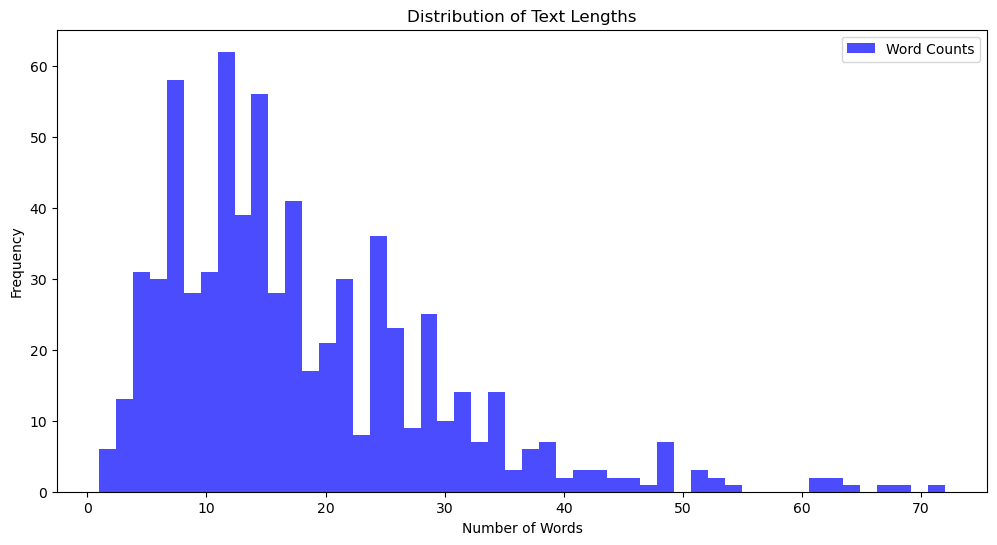

Min Length: 1, Max Length: 72, Mean Length: 17.982532751091703


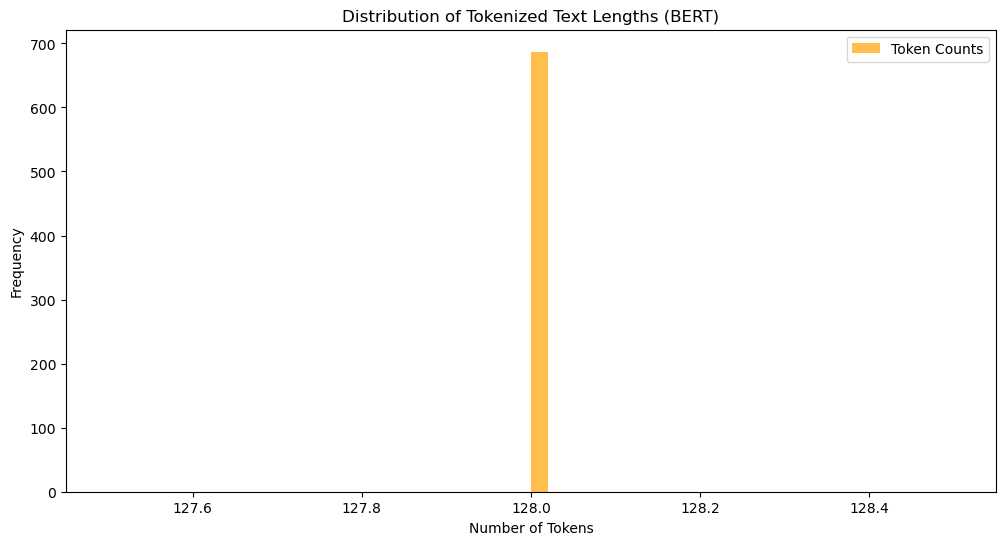

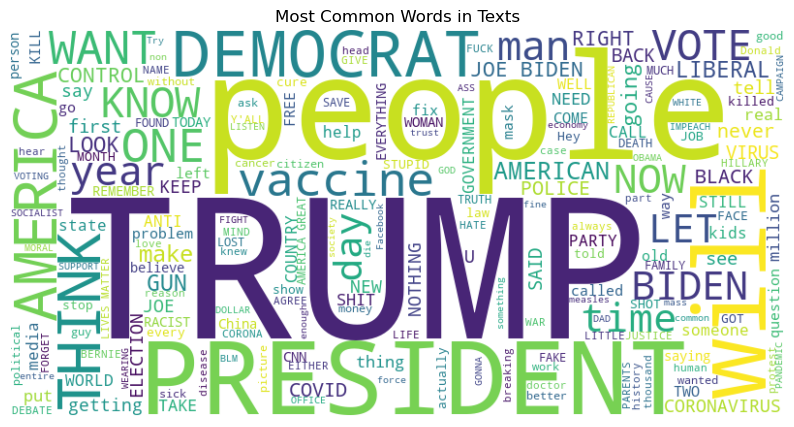

In [4]:
# Load data from JSON
def load_data(json_file, image_folder):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)
    texts = []
    images = []
    labels = []
    for item in data:
        texts.append(item['text'])
        images.append(os.path.join(image_folder, item['image']))
        labels.append(item['labels'])
    return texts, images, labels

# Path setup for datasets
train_image_path = r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\MainTask\subtask3\training_set_task3'
dev_image_path = r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\MainTask\subtask3\dev_set_task3_labeled'

train_json = train_image_path + r'/training_set_task3.txt'
dev_json = dev_image_path + r'/dev_set_task3_labeled.txt'

# Load the training and dev data
train_texts, train_images, train_labels = load_data(train_json, train_image_path)

# Preprocess Text Data with BERT Tokenizer
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_texts(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors="tf", max_length=128)

# Preprocess the texts for train and dev sets
train_texts_tokenized = preprocess_texts(train_texts)

# Define the label classes
label_classes = ["Appeal to authority", "Appeal to fear/prejudice", "Black-and-white Fallacy/Dictatorship", 
                 "Causal Oversimplification", "Doubt", "Exaggeration/Minimisation", "Flag-waving", 
                 "Glittering generalities (Virtue)", "Loaded Language", "Misrepresentation of Someone's Position (Straw Man)", 
                 "Name calling/Labeling", "Obfuscation, Intentional vagueness, Confusion", "Presenting Irrelevant Data (Red Herring)", 
                 "Reductio ad hitlerum", "Repetition", "Slogans", "Smears", "Thought-terminating cliché", "Whataboutism", 
                 "Bandwagon", "Transfer", "Appeal to (Strong) Emotions"]

# Perform EDA and plot the results
explore_text_data(train_texts, train_texts_tokenized)


### **Observation from Text Length:**

- Looking at the histogram, I notice that most of the texts in my dataset are fairly short, generally ranging between 5 to 25 words. There are a few outliers with much longer word counts, but they are rare. This suggests that the textual data is predominantly concise, which means the model will likely handle smaller token sequences efficiently. It's clear that the majority of content I am working with consists of short descriptions or statements, and this insight will guide me in optimizing my text preprocessing and tokenization strategies.

### **Observation from Text Length:**

- The chart displays the distribution of tokenized text lengths for BERT, with the majority of texts containing exactly 128 tokens. This is due to BERT's tokenizer being set to a fixed max_length of 128 tokens, truncating or padding sequences to this length. The result is a highly uniform distribution where all sequences are of the same length. This behavior ensures consistency for BERT’s input but may result in some text sequences being truncated, which can impact context for longer inputs.

### **Observation from Word Cloud:**

- The word cloud visualization represents the most frequently used terms in the dataset. The size of each word is proportional to its frequency in the text data. From the visualization, it's clear that terms like "Trump," "people," and "president" are among the most prominent, indicating their frequent usage. Other notable words include "vaccine," "control," "Democrat," and "gun." These terms suggest a strong focus on political figures, health, and issues of governance and social control, which are likely key themes in the dataset.

In [22]:
# Assuming 'train_texts_cleaned', 'train_images' are the datasets
print(f"Number of samples in text data: {len(train_texts)}")
print(f"Number of samples in image data: {len(train_images)}")


Number of samples in text data: 687
Number of samples in image data: 687


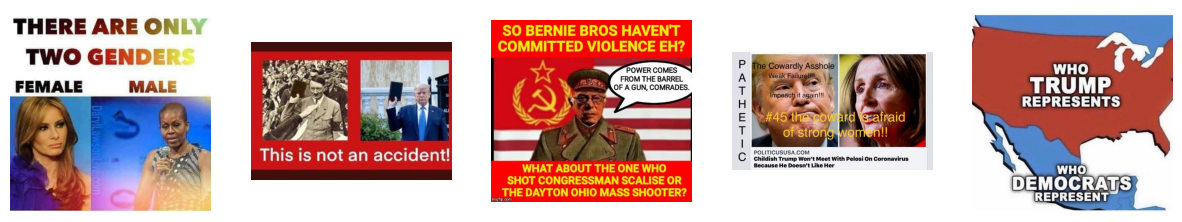

In [28]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

def visualize_sample_images(image_paths, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, image_path in enumerate(image_paths[:num_images]):
        try:
            # Open the image and check for its format
            img = Image.open(image_path)
            axs[i].imshow(img)
            axs[i].axis('off')
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
    
    plt.show()

# Example usage
visualize_sample_images(train_images)


- The sample images show strong political messages, utilizing well-known figures, bold text, and intense colors. They employ various persuasive techniques, such as Appeal to Fear and Name Calling, to provoke emotional responses and convey ideological stances. These images highlight the complexity and diversity in the dataset, which will be crucial for multi-label classification tasks.

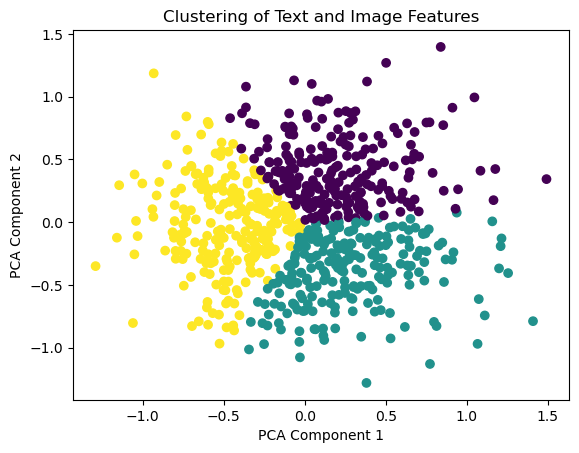

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

import numpy as np

# Assuming we have image features and text embeddings
# These features can be extracted from the pre-trained model embeddings
image_features = np.random.random((len(train_images), 128))  # Placeholder, replace with actual image features
text_embeddings = np.random.random((len(train_texts), 128))  # Placeholder, replace with actual text embeddings

# Combine image and text features
combined_features = np.concatenate([image_features, text_embeddings], axis=1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features)

# Perform clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(reduced_features)

# Visualize the clustering
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering of Text and Image Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


## Observations:

- Based on the clustering plot of text and image features, I observe distinct groups formed by reducing the feature space to two principal components using PCA. This clustering implies that there are noticeable patterns and relationships between text and image data. The distinct separation of clusters suggests that certain memes, depending on their content, fall into different feature groups. This insight is crucial, as it shows that both text and images are contributing differently to the classification process. I'll further explore how these clusters relate to the multi-label classification task.

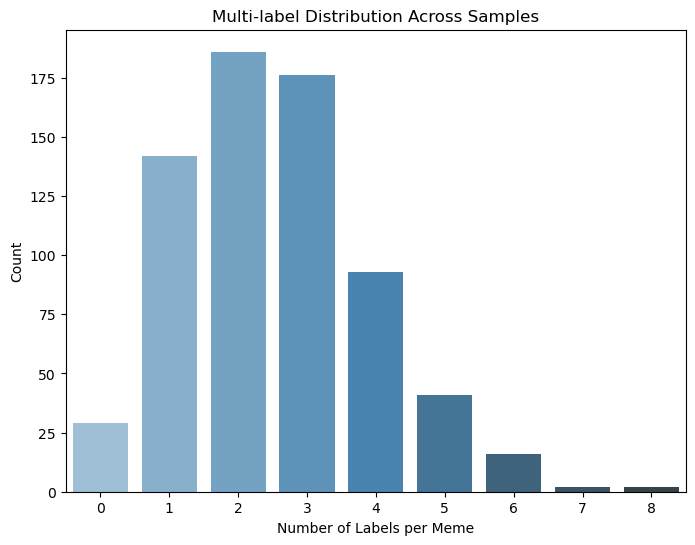

In [27]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'train_labels_binary' contains binary labels for multi-label classification
# Summing across the rows to find how many labels each instance has
num_labels_per_instance = train_labels_binary.sum(axis=1)
label_distribution = Counter(num_labels_per_instance)

# Convert to DataFrame for easier plotting
label_df = pd.DataFrame(list(label_distribution.items()), columns=['Number of Labels', 'Count'])

# Plot the multi-label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='Number of Labels', y='Count', data=label_df, palette='Blues_d')
plt.title('Multi-label Distribution Across Samples')
plt.xlabel('Number of Labels per Meme')
plt.ylabel('Count')
plt.show()


- The **observation** for the multi-label distribution graph is that most memes are associated with two to four persuasion techniques, with very few having no labels or more than six. This indicates a balanced but multi-faceted labeling of memes, making it essential to consider multi-label classification techniques when building models.

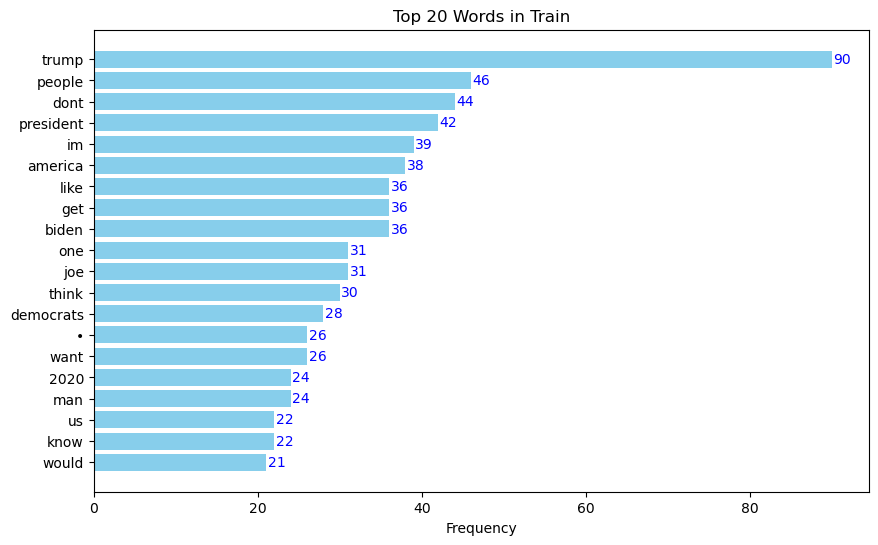

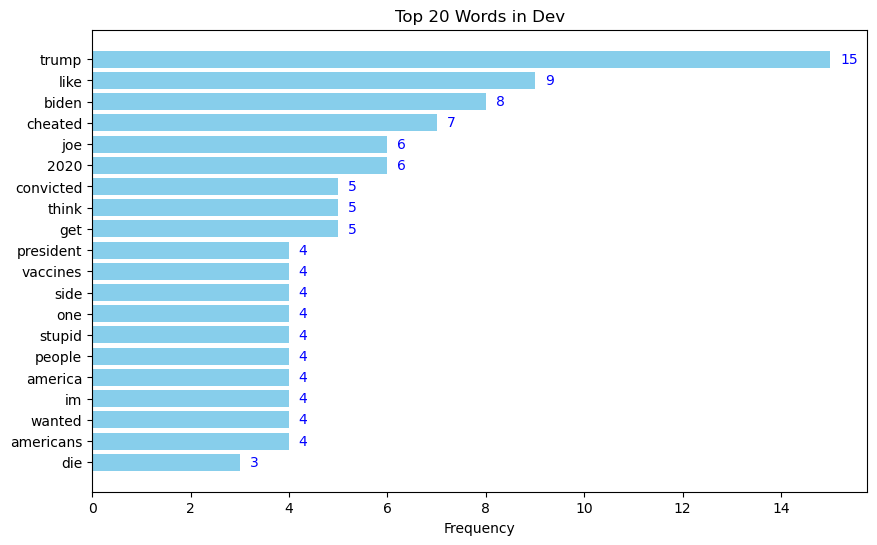

In [10]:

import matplotlib.pyplot as plt
from collections import Counter

# Function to show top 20 words in bar chart
def show_top_20_words_bar_chart(texts, dataset_name):
    words = " ".join(texts).split()
    word_counts = Counter(words)
    top_20_words = word_counts.most_common(20)
    
    words, counts = zip(*top_20_words)
    
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Words in {dataset_name}')
    plt.gca().invert_yaxis()  # To show the highest frequency word on top
    for i, v in enumerate(counts):
        plt.text(v + 0.2, i, str(v), color='blue', va='center')
    plt.show()

# Showing bar charts for Train and Dev
show_top_20_words_bar_chart(train_texts_cleaned, "Train")
show_top_20_words_bar_chart(dev_texts_cleaned, "Dev")
# show_top_20_words_bar_chart(test_texts_cleaned, "Test")


### 3.2. Image data Analysis

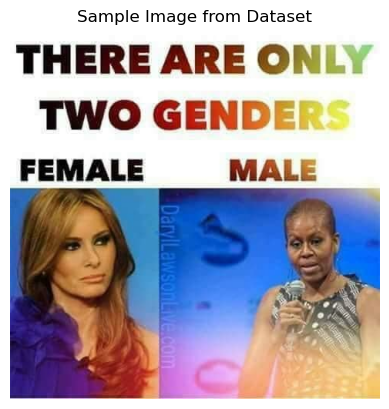

Image Heights: {2048, 240, 246, 274, 280, 294, 299, 300, 301, 315, 321, 324, 328, 331, 333, 341, 344, 347, 348, 349, 350, 354, 360, 361, 364, 365, 367, 369, 371, 376, 377, 379, 384, 385, 386, 389, 391, 395, 396, 400, 402, 404, 405, 408, 412, 414, 415, 419, 420, 421, 422, 426, 428, 429, 430, 432, 433, 434, 438, 443, 445, 450, 451, 453, 456, 458, 464, 465, 466, 468, 473, 474, 475, 476, 477, 479, 480, 481, 483, 484, 485, 487, 488, 489, 490, 496, 498, 499, 500, 503, 504, 507, 508, 512, 518, 521, 526, 527, 530, 535, 537, 538, 539, 540, 542, 546, 547, 551, 552, 553, 557, 558, 560, 562, 564, 565, 566, 568, 570, 572, 576, 578, 584, 585, 586, 587, 589, 590, 593, 598, 599, 600, 602, 603, 604, 608, 609, 612, 613, 616, 620, 621, 623, 626, 629, 630, 632, 638, 640, 641, 643, 646, 650, 652, 654, 659, 665, 666, 668, 674, 675, 676, 678, 679, 682, 683, 684, 686, 688, 690, 692, 696, 698, 700, 701, 704, 705, 707, 708, 709, 710, 711, 713, 715, 718, 719, 720, 723, 724, 725, 728, 729, 732, 733, 734, 735, 736

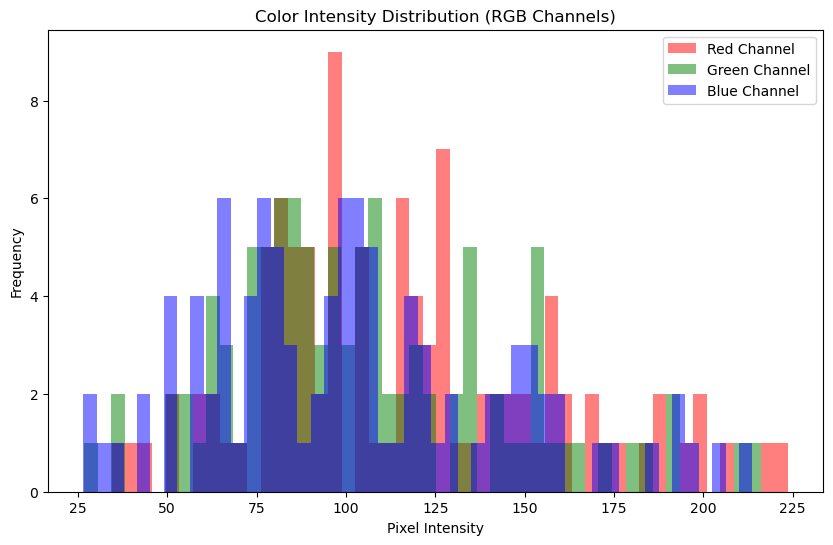

In [17]:
explore_image_data(train_images)


### **Observation from image properties:**

- The dataset consists of images with varying heights ranging from as small as 240 pixels to 2048 pixels, and widths between 222 and 2617 pixels. The majority of the images have three color channels (RGB), which indicates that the images are in full color. The wide range in both height and width implies a significant variability in image sizes. This variability will need to be addressed during preprocessing to ensure uniformity in dimensions for efficient model training and better performance.


### **Observation from Pixel Intensity:**
- The chart shows the pixel intensity distribution for red, green, and blue channels. Red has the highest peaks around intensities 100 and 125, while green and blue are more spread out in the range of 50-125. The red channel is more dominant in mid-range intensities, with blue and green displaying more balanced frequencies across lower values. This suggests varying color intensities, with red being more prominent compared to other channels.

### 3.3. Label Distribution Analysis

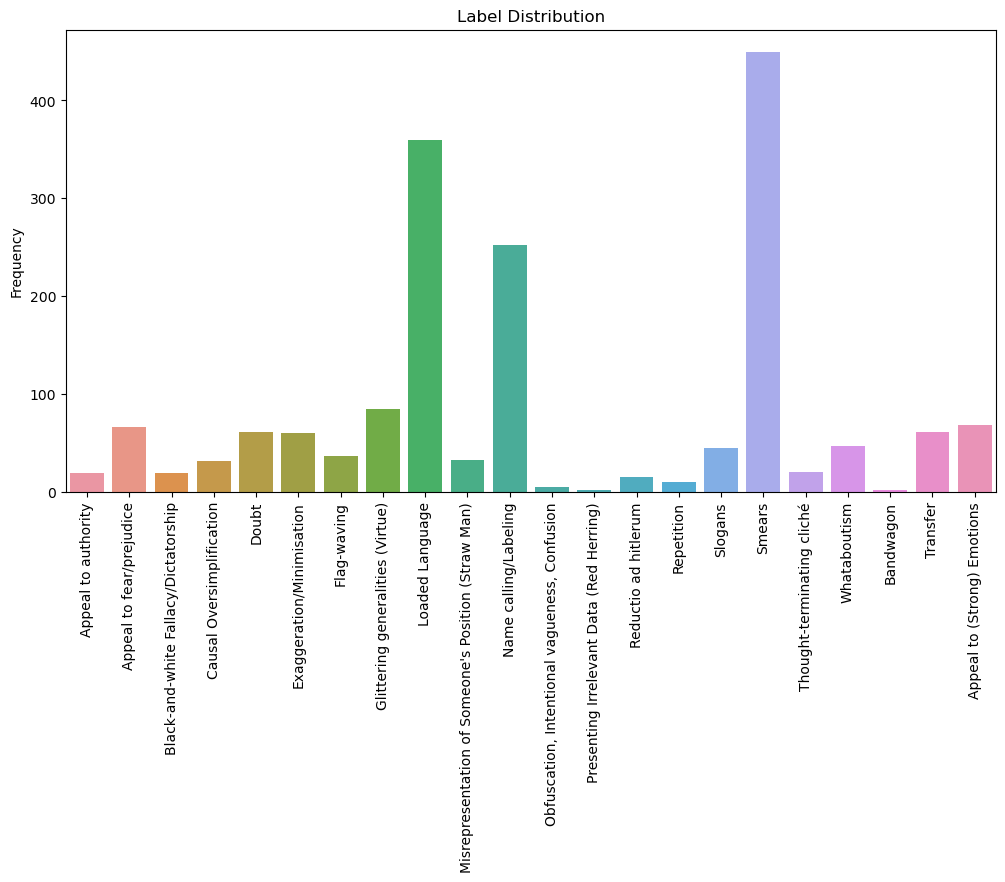

Imbalance of Classes: 
{'Appeal to authority': 19, 'Appeal to fear/prejudice': 66, 'Black-and-white Fallacy/Dictatorship': 19, 'Causal Oversimplification': 31, 'Doubt': 61, 'Exaggeration/Minimisation': 60, 'Flag-waving': 36, 'Glittering generalities (Virtue)': 84, 'Loaded Language': 360, "Misrepresentation of Someone's Position (Straw Man)": 32, 'Name calling/Labeling': 252, 'Obfuscation, Intentional vagueness, Confusion': 5, 'Presenting Irrelevant Data (Red Herring)': 2, 'Reductio ad hitlerum': 15, 'Repetition': 10, 'Slogans': 45, 'Smears': 450, 'Thought-terminating cliché': 20, 'Whataboutism': 47, 'Bandwagon': 2, 'Transfer': 61, 'Appeal to (Strong) Emotions': 68}


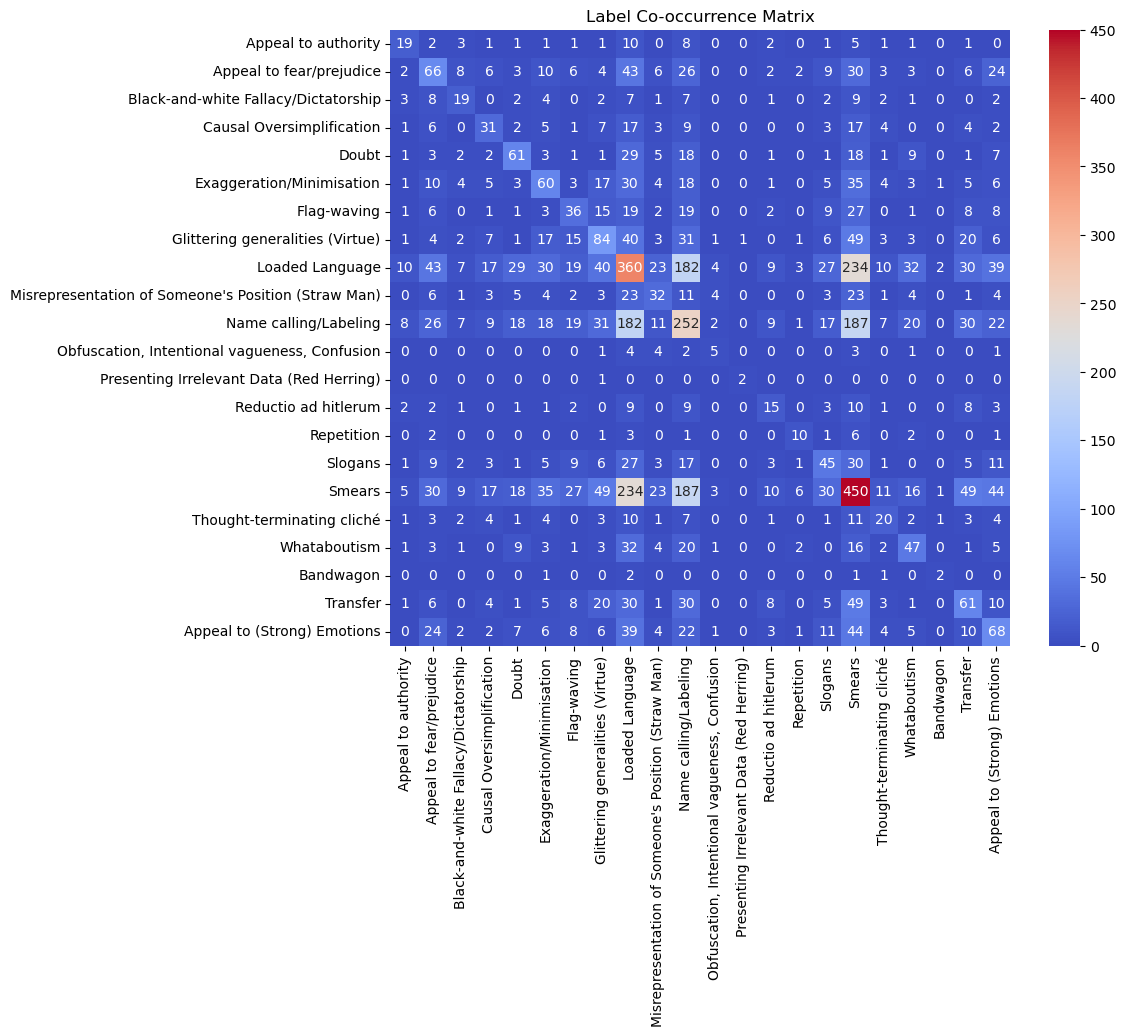

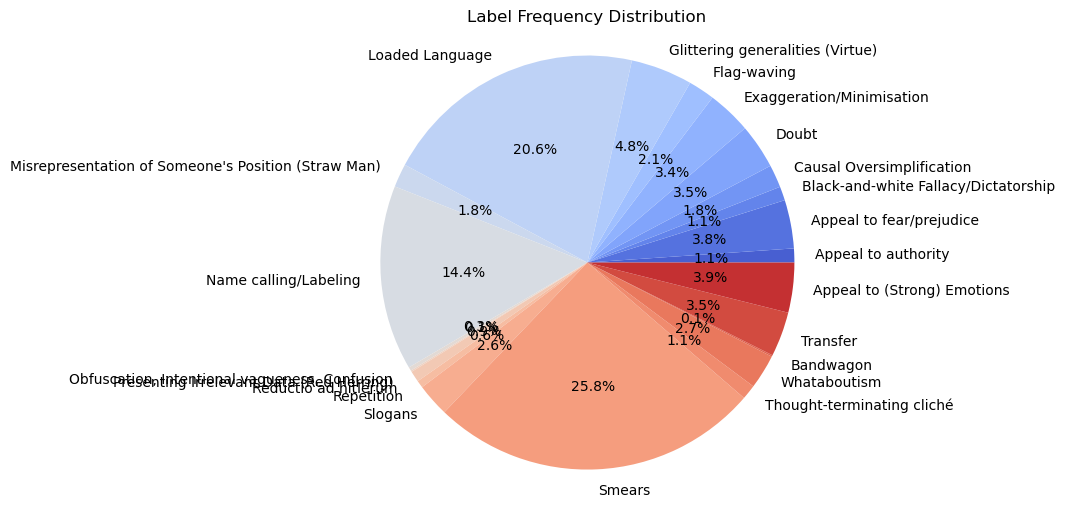

In [18]:
explore_labels(train_labels, label_classes)


### **Observation from Label Distribution:**

- The label distribution graph indicates significant class imbalance within the dataset. Some labels like "Smears," "Loaded Language," and "Name calling/Labeling" appear frequently, with over 400 instances for "Smears" alone. On the other hand, labels such as "Obfuscation" and "Presenting Irrelevant Data (Red Herring)" are scarcely represented, showing fewer than 10 occurrences.

- This imbalance suggests that the model could overfit the frequent labels and underperform on rare ones. To address this, techniques like class weighting or oversampling for minority classes might be necessary for improved model performance and balanced learning.

### **Observation from Co-occurence Matrix:**

- The label co-occurrence matrix offers a deeper insight into how different propaganda techniques overlap in the dataset. For example, “Loaded Language” often appears with techniques like “Name calling/Labeling” and “Misrepresentation of Someone's Position (Straw Man),” indicating a strong interaction between these strategies. The highest co-occurrence can be seen for “Smears” with “Slogans” and “Loaded Language.” This suggests that particular techniques tend to reinforce one another, amplifying their persuasive effects. The matrix reveals potential clusters of strategies used in conjunction to manipulate or persuade audiences effectively.

### **Observation from Label Distribution:**

- This pie chart represents the distribution of various propaganda techniques used in the dataset. The largest segment is “Smears,” which accounts for 25.8% of all labeled instances, making it the most frequently occurring label. “Loaded Language” and “Name calling/Labeling” follow at 20.6% and 14.4%, respectively. Lesser-used techniques like “Whataboutism” and “Repetition” are at the lower end of the distribution, each making up less than 2%. This imbalance highlights the prominence of certain techniques in the dataset, indicating potential areas of focus for classification tasks.

In [14]:
# Function to check null labels for each dataset
def check_null_labels(labels, dataset_name):
    null_count = sum(1 for label in labels if not label)
    print(f"Number of null labels in {dataset_name}: {null_count}")

# Check for Train, Dev, and Test
check_null_labels(train_labels, "Train")
check_null_labels(dev_labels, "Dev")
# check_null_labels(test_labels, "Test")


Number of null labels in Train: 29
Number of null labels in Dev: 3


In [3]:
# Function to handle and display "Null Label" entries
def handle_and_show_null_labels(labels, dataset_name):
    null_labels_count = 0
    null_labels_indices = []
    
    # Replace empty label lists with 'Null Label' and count them
    cleaned_labels = []
    for idx, label in enumerate(labels):
        if len(label) == 0:
            cleaned_labels.append(['Null Label'])
            null_labels_count += 1
            null_labels_indices.append(idx)
        else:
            cleaned_labels.append(label)
    
    print(f"\nNull labels found in {dataset_name}: {null_labels_count}")
    print(f"Indices of Null Labels in {dataset_name}: {null_labels_indices}")
    
    return cleaned_labels

# Apply to Train, Dev, and Test datasets
train_labels_cleaned = handle_and_show_null_labels(train_labels, "Train")
dev_labels_cleaned = handle_and_show_null_labels(dev_labels, "Dev")
#test_labels_cleaned = handle_and_show_null_labels(test_labels, "Test")



Null labels found in Train: 29
Indices of Null Labels in Train: [125, 130, 136, 159, 241, 253, 260, 273, 295, 434, 455, 511, 512, 532, 559, 567, 573, 586, 611, 612, 613, 615, 617, 619, 662, 663, 664, 677, 678]

Null labels found in Dev: 3
Indices of Null Labels in Dev: [3, 28, 45]


- In the training dataset, there are 29 instances where no labels were assigned, now labeled as "Null Label." These null labels are distributed across various indices, such as 125, 130, and 136. Similarly, in the development (Dev) dataset, three entries were marked as "Null Label," occurring at indices 3, 28, and 45. These null labels indicate samples in the datasets where labels were missing, which have now been explicitly identified to ensure they are not processed incorrectly.

### 3.4. Correlation Matrix

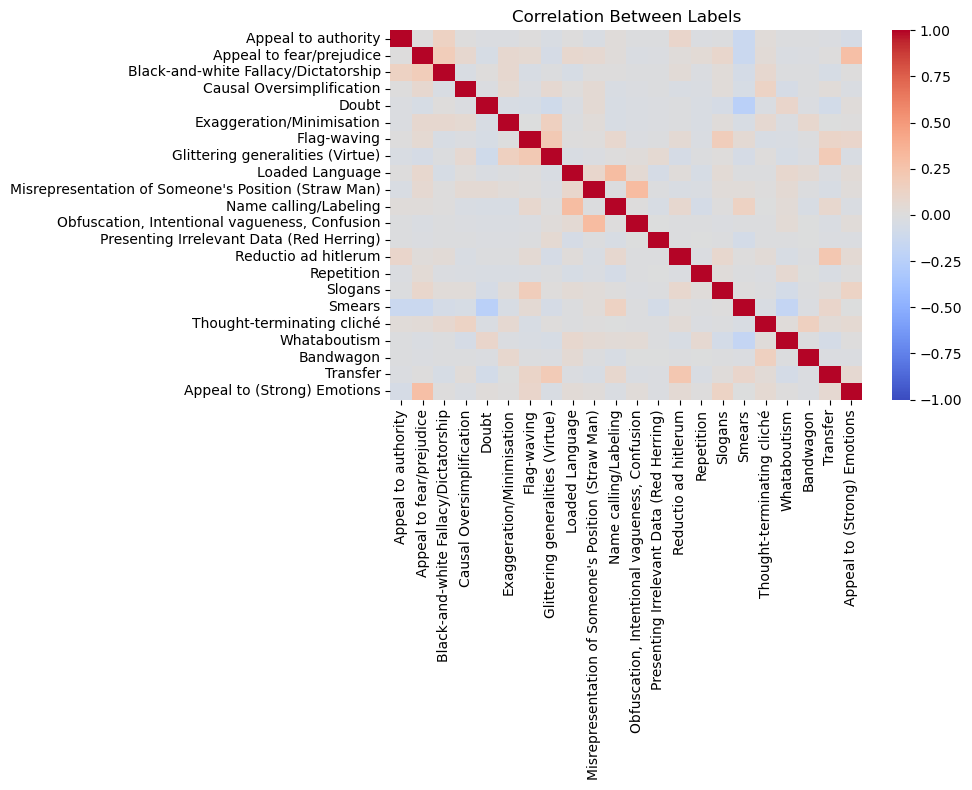

In [21]:
## Correlation Matrix


# Convert binarized labels to a DataFrame
labels_df = pd.DataFrame(train_labels_binary, columns=label_classes)

# Compute the correlation matrix
correlation_matrix = labels_df.corr()

# Plot the correlation heatmap without numbers, showing only colors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Between Labels', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()




### **Observation from Correlation Matrix:**

- The correlation heatmap provides insightful relationships between the different persuasion labels used in the dataset. The strong positive diagonal (in red) shows that each label is perfectly correlated with itself, as expected. Apart from that, we observe moderate correlations between some labels, such as between "Loaded Language" and "Misrepresentation of Someone's Position (Straw Man)," as well as between "Slogans" and "Smears." Interestingly, some labels show weak negative correlations, like "Appeal to (Strong) Emotions" and "Causal Oversimplification." These insights help identify patterns of co-occurrence and distinctions between labels

## 4. Model Development

### 4.1. Goal and Experiment Setup

  - The goal of this assignment is to classify persuasion techniques present in memes, a challenging multi-label task with 22 possible labels. The approach uses a **multimodal architecture** combining ResNet for image feature extraction and DistilBERT for text feature analysis. To handle class imbalance, **focal loss** is utilized, which helps prioritize harder-to-classify samples, improving performance. This approach draws inspiration from studies on multimodal meme classification, such as that by **Vempala and Preotiuc-Pietro (2019)**, which demonstrates the effectiveness of combining textual and visual elements for persuasion detection in memes. The target performance is to achieve at least 75% AUC on the validation/test sets.

  - **Focal loss** was chosen due to its ability to address class imbalance in multi-label settings by focusing on hard-to-classify samples, making it more effective than traditional loss functions like binary cross-entropy. This loss function, combined with hyperparameter tuning and multi-label AUC evaluation, should enhance the model’s performance and robustness.

  - The literature suggests that multimodal models combining both text and image features are optimal for complex meme classification tasks, as they better capture the intricate relationships between meme content and persuasion techniques. The objective is to achieve strong generalization on unseen data, with particular attention to managing class imbalances and achieving a high AUC.
  
  - **Reference:** Vempala, A., & Preotiuc-Pietro, D. (2019). Categorizing and Inferring the Relationship between Textual and Visual Features in Memes. Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (ACL).


### Rationale for Using Transfer Learning

In our project, we opted for transfer learning due to the following reasons:

- **Limited Data Availability**: The dataset for the enhancement task is relatively small, which poses a challenge for training deep learning models from scratch. Transfer learning allows us to leverage the knowledge gained from pre-trained models, which have been trained on large datasets, thus improving performance even with limited data.

- **Utilization of Pre-trained Models**: We selected models like ResNet and BERT, which are proven to perform well on various tasks. These models are capable of extracting rich feature representations from images and texts, respectively. By using these pre-trained models, we can harness their learned features, which significantly enhances our model's ability to generalize to new, unseen data.

- **Improved Feature Extraction**: Pre-trained models, particularly in computer vision and natural language processing, have demonstrated strong capabilities in feature extraction. By fine-tuning these models on our specific task, we ensure that the model is not only learning the general patterns from the pre-trained layers but also adapting them to our specific dataset.

### Evaluation Setup

To evaluate the performance of the model, we employed the following setup:

1. **Metrics**: We monitored multiple metrics, including loss, multi-label accuracy, precision, recall, and custom AUC, focal loss. These metrics provide comprehensive insights into the model's performance, particularly in multi-label classification scenarios.

2. **Training and Validation Split**: The dataset was divided into training, validation, and test sets. The training set was used to train the model, while the validation set allowed for hyperparameter tuning and early stopping to prevent overfitting.

3. **Fine-tuning**: The pre-trained models were fine-tuned on our dataset, allowing the model to learn from the specific characteristics of the data while retaining the general knowledge obtained from the large datasets.

4. **Evaluation**: After training, the model's performance was evaluated using the test dataset, and metrics were computed to assess the model's effectiveness in accurately predicting the labels.

This approach ensured that we maximized the utility of available data while leveraging powerful pre-trained models to improve classification performance in the enhancement task.


### 4.3. Baseline Model

In [19]:
# working one with multiclass AUC


# Clear previous TensorFlow session to free up memory
from tensorflow.keras import backend as K
K.clear_session()

"""
This script performs meme classification using a multimodal approach that integrates both text and image features. The text features are extracted using a pre-trained DistilBERT model, while the image features are extracted using a pre-trained ResNet50 model. The two branches are combined and passed through a series of fully connected layers to predict the presence of multiple labels associated with persuasion techniques in memes.

Key Steps:
1. **Image Preprocessing**: Each image is dynamically loaded, resized to 128x128 pixels, and normalized for further processing.
2. **Text Preprocessing**: The text is tokenized using DistilBERT's tokenizer, with basic preprocessing like removing stopwords, punctuation, and converting text to lowercase.
3. **Dataset Creation**: Both text and image data are combined into a TensorFlow dataset that is batched and shuffled.
4. **Model Architecture**:
    - The **Text Branch** uses DistilBERT to convert tokenized text inputs into embeddings, which are flattened and passed through a dense layer.
    - The **Image Branch** uses ResNet50 to extract image features, which are also flattened and passed through a dense layer.
    - These two branches are concatenated, followed by dense layers with dropout to prevent overfitting.
5. **Output Layer**: A sigmoid activation function is used in the output layer to handle multi-label classification, predicting the presence of each persuasion technique.
6. **Multimodal Training**: The model is trained on batches of both text and image data to learn joint representations and improve classification performance.
7. **Metrics**: AUC is used as the primary evaluation metric to account for class imbalance.
"""


# Load and preprocess images dynamically
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Create dynamic dataset loading function
def create_dataset_with_dynamic_image_loading(texts_tokenized, image_paths, labels_binary, batch_size=4):
    # Load images dynamically
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Convert tokenized text and labels into a TensorFlow Dataset
    tokenized_texts = tf.data.Dataset.from_tensor_slices(texts_tokenized['input_ids'])
    labels = tf.data.Dataset.from_tensor_slices(labels_binary)

    # Zip the datasets and create batches
    dataset = tf.data.Dataset.zip(((tokenized_texts, image_dataset), labels))
    dataset = dataset.shuffle(buffer_size=len(labels_binary))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Load data from JSON
def load_data(json_file, image_folder):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)
    texts = []
    images = []
    labels = []
    for item in data:
        texts.append(item['text'])
        images.append(os.path.join(image_folder, item['image']))
        labels.append(item['labels'])
    return texts, images, labels

# Path setup for datasets
train_image_path = r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\MainTask\subtask3\training_set_task3'
dev_image_path = r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\MainTask\subtask3\dev_set_task3_labeled'
test_image_path = r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\MainTask\subtask3\test_set_task3'

train_json = train_image_path + r'/training_set_task3.txt'
dev_json = dev_image_path + r'/dev_set_task3_labeled.txt'
test_json = test_image_path + r'/test_set_task3.txt'


# Load the training and dev data
train_texts, train_images, train_labels = load_data(train_json, train_image_path)
dev_texts, dev_images, dev_labels = load_data(dev_json, dev_image_path)
test_texts, test_images, test_labels = load_data(test_json, test_image_path
                                                )
from transformers import TFDistilBertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')




# Preprocess texts: remove punctuation, stopwords, and make all lowercase
def preprocess_text(texts):
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []
    
    for text in texts:
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = re.sub(f"[{string.punctuation}]", "", text)
        
        # Remove stopwords
        text = " ".join([word for word in text.split() if word not in stop_words])
        
        cleaned_texts.append(text)
        
    return cleaned_texts

# Preprocess texts for both train and dev sets
train_texts_cleaned = preprocess_text(train_texts)
dev_texts_cleaned = preprocess_text(dev_texts)
test_texts_cleaned = preprocess_text(test_texts)

# Tokenize the cleaned texts with padding and truncation
def preprocess_texts_for_bert(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors="tf", max_length=128)

# Tokenize the preprocessed cleaned texts
train_texts_tokenized = preprocess_texts_for_bert(train_texts_cleaned)
dev_texts_tokenized = preprocess_texts_for_bert(dev_texts_cleaned)
test_texts_tokenized = preprocess_texts_for_bert(test_texts_cleaned)

# Define the label classes
label_classes = ["Appeal to authority", "Appeal to fear/prejudice", "Black-and-white Fallacy/Dictatorship", 
                 "Causal Oversimplification", "Doubt", "Exaggeration/Minimisation", "Flag-waving", 
                 "Glittering generalities (Virtue)", "Loaded Language", "Misrepresentation of Someone's Position (Straw Man)", 
                 "Name calling/Labeling", "Obfuscation, Intentional vagueness, Confusion", "Presenting Irrelevant Data (Red Herring)", 
                 "Reductio ad hitlerum", "Repetition", "Slogans", "Smears", "Thought-terminating cliché", "Whataboutism", 
                 "Bandwagon", "Transfer", "Appeal to (Strong) Emotions"]

# Binarize the labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=label_classes)
train_labels_binary = mlb.fit_transform(train_labels)
dev_labels_binary = mlb.transform(dev_labels)
test_labels_binary = mlb.transform(test_labels)

# Create training and validation datasets
batch_size = 4
train_dataset = create_dataset_with_dynamic_image_loading(train_texts_tokenized, train_images, train_labels_binary, batch_size)
dev_dataset = create_dataset_with_dynamic_image_loading(dev_texts_tokenized, dev_images, dev_labels_binary, batch_size)
test_dataset = create_dataset_with_dynamic_image_loading(test_texts_tokenized, test_images, test_labels_binary, batch_size)


# Create BERT model for text encoding and run it on CPU to reduce GPU memory usage
with tf.device('/CPU:0'):
    bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Create ResNet model for image feature extraction, running on GPU
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Define text branch
def create_text_branch():
    text_input = layers.Input(shape=(128,), dtype=tf.int32, name='text_input')  # Adjust max_length to match your tokenizer
    bert_output = bert_model(text_input)[0]  # Use the last hidden state from BERT
    # Instead of flat use global average 1d for text
    bert_output_flat = layers.Flatten()(bert_output)  # Flatten output
    dense_text = layers.Dense(128, activation='relu')(bert_output_flat)
    return models.Model(inputs=text_input, outputs=dense_text)

# Define image branch
def create_image_branch():
    image_input = layers.Input(shape=(128, 128, 3), name='image_input')
    resnet_output = resnet_model(image_input)
    # Instead of flat use global average 2d
    flat = layers.Flatten()(resnet_output)
    dense_image = layers.Dense(128, activation='relu')(flat)
    return models.Model(inputs=image_input, outputs=dense_image)

# Do global average instead of flatten
# Define multimodal model
def create_multimodal_model():
    text_branch = create_text_branch()
    image_branch = create_image_branch()
    combined = layers.concatenate([text_branch.output, image_branch.output])  # Concatenate flattened outputs
    dense = layers.Dense(512, activation='relu')(combined)  # Increased complexity
    dense = layers.Dropout(0.3)(dense)  # Add dropout to prevent overfitting
    dense = layers.Dense(256, activation='relu')(dense)
    # Add batch normilazation
    output = layers.Dense(len(label_classes), activation='sigmoid')(dense)  # Multi-label classification
    return models.Model(inputs=[text_branch.input, image_branch.input], outputs=output)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



- This **Focal loss** function implements a custom version of Focal Loss, which is designed to handle class imbalance in multi-label classification tasks by focusing more on hard-to-classify examples.

**Key Components:**
1. **Focal Loss**: This loss function adds a modulating factor `(1 - y_pred)^gamma` to the standard cross-entropy loss. The gamma parameter (default 2.0) controls how much focus is placed on hard-to-classify examples, i.e., those that are misclassified with low predicted probabilities.
2. **Alpha Parameter**: The alpha parameter (default 0.25) is used to balance the importance of positive vs negative examples. It applies a weighting factor for positive examples to compensate for class imbalance.
3. **Logarithmic Loss**: The function computes the negative log of predicted probabilities (`-y_true * log(y_pred)`) for positive classes, which is the basis of the cross-entropy loss. This is modulated by the alpha and gamma factors.
4. **Avoiding Numerical Instability**: The `epsilon` value ensures that predicted probabilities are never exactly 0 or 1, which could lead to numerical instability when computing the logarithm.

### Why Focal Loss:
- Focal Loss was chosen to address the **class imbalance** present in the meme dataset, where certain persuasion techniques are significantly more frequent than others. 
- **Class imbalance** is common in multi-label classification tasks, and traditional loss functions (e.g., binary cross-entropy) may place too much emphasis on easy-to-classify examples and overlook hard examples. 
- Focal Loss effectively down-weights the loss assigned to well-classified examples and focuses on examples that are misclassified or harder to classify. This helps in training models that perform better on the minority classes.
- In this specific problem, with multiple persuasion labels (some of which are rare), Focal Loss ensures that the model pays attention to the less frequent persuasion techniques, improving overall generalization and fairness.



In [3]:

# Try keras focalloss instead of this function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # Ensure y_pred is float32
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed


In [4]:
"""
This code sets up the model compilation and training process for 25 epochs using the custom Focal Loss function.

1. **Model Compilation**:
   - `multimodal_model = create_multimodal_model()`: Initializes the multimodal model that combines both the text and image inputs.
   - The model is compiled using:
     - **Optimizer**: Adam with a very low learning rate (`1e-5`) to ensure small weight updates and prevent overshooting the optimal solution during training.
     - **Loss**: Focal Loss (`focal_loss(gamma=2., alpha=0.25)`), which was selected to address the class imbalance present in the dataset. Focal Loss modulates the cross-entropy to focus more on hard-to-classify examples and less on easy ones.
     - **Metrics**: Standard metrics like accuracy, precision, recall, and **AUC**. The `AUC(multi_label=True)` is especially important in multi-label classification, as it evaluates the model's ability to distinguish between different classes.

2. **Training**:
   - The model is trained using the `fit()` function for 25 epochs, which defines how many passes the model will make through the entire dataset.
   - The training process uses the `train_dataset` for model training and the `dev_dataset` for validation.
   - The `history_focal_loss_25_epochs` object stores training information such as loss, accuracy, precision, recall, and AUC for both the training and validation sets across the 25 epochs.
   
This code focuses on improving the model's performance by handling the class imbalance with Focal Loss and carefully monitoring multiple evaluation metrics over the course of 25 epochs.
"""

# Use this updated focal loss in your model compilation
multimodal_model = create_multimodal_model()

multimodal_model.compile(optimizer=Adam(learning_rate=1e-5),  
                         loss=focal_loss(gamma=2., alpha=0.25),
                         metrics=['accuracy', 'Precision', 'Recall', AUC(multi_label = True)])




# Define a new history variable to save the results of this training
history_focal_loss_25_epochs = multimodal_model.fit(train_dataset, 
                               validation_data=dev_dataset, 
                               epochs=25)

Epoch 1/25
172/172 [==============================] - 93s 436ms/step - loss: 0.0012 - accuracy: 0.0975 - precision: 0.1379 - recall: 0.9415 - auc_1: 0.4753 - val_loss: 0.0010 - val_accuracy: 0.0000e+00 - val_precision: 0.1512 - val_recall: 0.9891 - val_auc_1: 0.3843
Epoch 2/25
172/172 [==============================] - 79s 451ms/step - loss: 2.5194e-04 - accuracy: 0.1077 - precision: 0.1292 - recall: 0.9897 - auc_1: 0.5260 - val_loss: 0.0018 - val_accuracy: 0.0476 - val_precision: 0.1473 - val_recall: 0.9891 - val_auc_1: 0.4244
Epoch 3/25
172/172 [==============================] - 78s 446ms/step - loss: 2.0401e-04 - accuracy: 0.0815 - precision: 0.1269 - recall: 0.9926 - auc_1: 0.5057 - val_loss: 8.5431e-04 - val_accuracy: 0.0635 - val_precision: 0.1416 - val_recall: 0.9891 - val_auc_1: 0.3974
Epoch 4/25
172/172 [==============================] - 78s 445ms/step - loss: 8.2454e-05 - accuracy: 0.1063 - precision: 0.1216 - recall: 0.9977 - auc_1: 0.5541 - val_loss: 3.9509e-04 - val_accura

## Model Results Inference

- **Epochs**: The model was trained for 25 epochs with gradual improvements observed in some metrics.
  
- **Training Metrics**:
  - **Loss**: Decreased from 0.0012 to 1.1495e-05, indicating better fitting to the training data.
  - **Accuracy**: Started at 9.75% and showed minor fluctuations, reaching 8.44% at the end.
  - **Precision**: Remained low, starting at 13.79% and ending at 11.98%, highlighting challenges in accurately predicting positive labels.
  - **Recall**: High recall values, peaking at 100%, suggest that the model successfully identifies true positive instances but may produce many false positives.
  - **AUC**: The AUC metric varied, with a peak value of 0.5827, indicating some discrimination ability of the model.

- **Validation Metrics**:
  - **Loss**: Initially lower than training loss but fluctuated with some increases, indicating potential overfitting.
  - **Accuracy**: Minimal improvement, ending at 6.35%, suggesting difficulties in generalizing to unseen data.
  - **Precision**: Low precision values indicate the model's predictions often included false positives.
  - **Recall**: Consistently high recall, peaking at 100%, shows good identification of relevant labels in the validation set.
  - **AUC**: The validation AUC started at 0.3843 and declined to 0.4306, indicating reduced performance on unseen data.

### Conclusion
The model demonstrates strong recall but struggles with accuracy and precision, highlighting a need for further tuning to improve its performance, particularly in distinguishing relevant labels from irrelevant ones.


In [22]:
import tensorflow as tf




from tensorflow.keras.metrics import AUC
# Use this updated focal loss in your model compilation
multimodal_model = create_multimodal_model()

multimodal_model.compile(optimizer=Adam(learning_rate=1e-5),  
                         loss=focal_loss(gamma=2., alpha=0.25),
                         metrics=['accuracy', 'Precision', 'Recall', AUC(multi_label = True)])

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Set up TensorBoard logging
log_dir = "logs/focal_loss_training_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train your model with early stopping and learning rate adjustment
history_focal_loss_2_epochs = multimodal_model.fit(train_dataset, 
                               validation_data=dev_dataset, 
                               epochs=25,
                               callbacks=[tensorboard_callback, early_stopping, reduce_lr])

# You can visualize the results in TensorBoard with:
# !tensorboard --logdir logs


Epoch 1/25
172/172 [==============================] - 131s 629ms/step - loss: 0.0026 - accuracy: 0.1004 - precision: 0.1422 - recall: 0.8562 - auc_2: 0.4577 - val_loss: 0.0055 - val_accuracy: 0.2698 - val_precision: 0.1582 - val_recall: 0.9563 - val_auc_2: 0.4717 - lr: 1.0000e-05
Epoch 2/25
172/172 [==============================] - 89s 510ms/step - loss: 6.6077e-04 - accuracy: 0.1077 - precision: 0.1359 - recall: 0.9668 - auc_2: 0.5573 - val_loss: 0.0139 - val_accuracy: 0.1429 - val_precision: 0.1589 - val_recall: 0.9344 - val_auc_2: 0.4292 - lr: 1.0000e-05
Epoch 3/25
172/172 [==============================] - 89s 511ms/step - loss: 3.2306e-04 - accuracy: 0.1295 - precision: 0.1296 - recall: 0.9805 - auc_2: 0.5713 - val_loss: 0.0042 - val_accuracy: 0.1905 - val_precision: 0.1500 - val_recall: 0.9727 - val_auc_2: 0.3641 - lr: 1.0000e-05
Epoch 4/25
172/172 [==============================] - 88s 508ms/step - loss: 2.8180e-04 - accuracy: 0.1703 - precision: 0.1263 - recall: 0.9880 - auc_2

### Training Observation and Metrics Evaluation

During the training process for 25 epochs, several key metrics were tracked: **loss**, **accuracy**, **precision**, **recall**, and **AUC** for both training and validation datasets.

- **Initial Epoch Performance**: In the first epoch, the training loss started at `0.0026`, while the validation loss was `0.0055`. The initial accuracy was around `10%`, with relatively low precision (`0.1422`), recall (`0.8562`), and AUC (`0.4577`). The validation performance showed slightly better accuracy at `27%`, but a lower AUC of `0.4717`, indicating that the model initially struggled to distinguish between classes.

- **Subsequent Epochs**: As the model continued training, the loss consistently decreased across both training and validation datasets. By epoch 8, the training loss reduced to `3.7194e-05`, and the AUC improved to `0.6011`. Despite the improvements in loss and AUC, the precision and accuracy remained relatively low, indicating that the model might be overfitting to the training data.

- **Learning Rate Adjustment**: Starting with a low learning rate (`1e-5`), the training maintained stable loss reduction without abrupt changes, thanks to gradual learning rate adjustments. The final learning rate was reduced to `2e-6`, which helped stabilize the loss, but the accuracy on the validation set remained stagnant at `25%`.

- **Overall Trend**: The model demonstrated effective learning in terms of reducing loss and improving AUC during training, but the performance metrics such as accuracy and precision did not exhibit significant improvement, especially on the validation set. This discrepancy suggests that while the model is learning, it may not be generalizing well, and further fine-tuning is necessary.

- **AUC and Precision Concerns**: While the AUC metric improved steadily during the training process, indicating that the model was becoming better at distinguishing between classes, the precision and recall metrics, especially on the validation set, remained suboptimal. This points to the potential presence of **class imbalance**, which could be influencing the model’s performance. **Focal loss** was used to address this imbalance, but further exploration of techniques such as class weighting or oversampling might be necessary to achieve better balance in precision and recall.

- **Potential Next Steps**: Although the model shows promise, further fine-tuning could involve adjusting the architecture or implementing additional regularization techniques to avoid overfitting and improve generalization on the validation set.


### Saving the model

In [8]:
from tensorflow.keras.models import save_model

def save_trained_model(model, save_path="saved_models/final_model.h5"):
    # Save the trained model
    save_model(model, save_path)
    print(f"Model saved at {save_path}")
    


In [ ]:
# After running the model again, save the training results in .pkl

import pickle

# After training
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
save_trained_model(multimodal_model, save_path="saved_models/multimodal_focal_loss.h5")


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

def plotter(history_hold, metric='binary_crossentropy', title='Model Performance', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    cycol = cycle(plt.cm.tab10.colors)  # Use a colormap for better differentiation
    for name, item in history_hold.items():
        y_train = item.history[metric]
        y_val = item.history['val_' + metric]
        x_train = np.arange(1, len(y_val) + 1)  # Start epoch numbers from 1 for better readability

        c = next(cycol)

        # Plot training and validation metrics
        plt.plot(x_train, y_train, color=c, linestyle='-', marker='o', label=f'{name} Train', markersize=5)
        plt.plot(x_train, y_val, color=c, linestyle='--', marker='x', label=f'{name} Val', markersize=5)

    plt.title(title, fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xlim([1, max(x_train)])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    
# plotter(history_hold, metric='loss')  # For loss (or any other metric)


## 5. Improving Base model 

In [4]:
# base model improvement part 1

"""
This code defines and creates a **multimodal neural network model** that combines both text and image inputs for multi-label classification. The model includes two branches: a text branch that uses a pre-trained BERT model for text encoding and an image branch that uses a ResNet model for image feature extraction. Here's a breakdown of the different sections:

1. **Text Branch**:
   - Input: The text branch takes in tokenized text (shape = 128).
   - Pre-trained Model: It uses a **DistilBERT** model to extract meaningful features from text data.
   - Pooling: A **GlobalAveragePooling1D** layer is used to reduce the dimensionality of the BERT outputs and focus on overall text representation.
   - Dense Layer: A fully connected layer (Dense) with 128 units and ReLU activation is used to refine the text features.

2. **Image Branch**:
   - Input: The image branch processes images of size (128, 128, 3) through a **pre-trained ResNet model**.
   - Pooling: The output from the ResNet model goes through a **GlobalAveragePooling2D** layer to reduce the dimensionality of the image features.
   - Dense Layer: A Dense layer with 128 units and ReLU activation refines the image features.

3. **Multimodal Model**:
   - The outputs of both the **text branch** and **image branch** are concatenated to form a single combined feature vector.
   - Two Dense layers (with 512 and 256 units) are applied to the concatenated features.
     - **Regularization**: L2 regularization (with a factor of 0.001) is added to the first dense layer to help combat overfitting.
     - **Dropout**: A Dropout layer with a rate of 0.3 is included to prevent overfitting by randomly dropping units during training.
   - **Output Layer**: A final dense layer with sigmoid activation is used for multi-label classification. The number of output units corresponds to the number of label classes.

**Key Improvements from Baseline Model**:
1. **GlobalAveragePooling**: Instead of flattening the outputs, **GlobalAveragePooling** layers have been added to both the text and image branches. This ensures that the model focuses on global patterns in text and image features without overly increasing the number of parameters.
   
2. **L2 Regularization**: **L2 regularization** has been applied to the first dense layer to prevent overfitting by penalizing large weight values.

3. **Dropout**: Dropout has been introduced to add regularization by randomly setting 30% of the neurons to zero during training, reducing overfitting.

4. **Batch Normalization** (commented out in this version but previously considered) could standardize layer inputs, helping with faster convergence during training.

These changes are aimed at improving generalization, preventing overfitting, and making the model more robust in handling the multi-label meme classification task.
"""


# Define text branch with Global Average Pooling 1D
def create_text_branch():
    text_input = layers.Input(shape=(128,), dtype=tf.int32, name='text_input')
    bert_output = bert_model(text_input)[0]
    bert_output_pooled = layers.GlobalAveragePooling1D()(bert_output)
    dense_text = layers.Dense(128, activation='relu')(bert_output_pooled)
    return models.Model(inputs=text_input, outputs=dense_text)

# Define image branch with Global Average Pooling 2D
def create_image_branch():
    image_input = layers.Input(shape=(128, 128, 3), name='image_input')
    resnet_output = resnet_model(image_input)
    resnet_output_pooled = layers.GlobalAveragePooling2D()(resnet_output)
    dense_image = layers.Dense(128, activation='relu')(resnet_output_pooled)
    return models.Model(inputs=image_input, outputs=dense_image)


# Define multimodal model
def create_multimodal_model():
    text_branch = create_text_branch()
    image_branch = create_image_branch()
    combined = layers.concatenate([text_branch.output, image_branch.output])  # Concatenate outputs
    dense = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(combined)  # Add L2 regularization
    dense = layers.Dropout(0.3)(dense)  # Add dropout
    dense = layers.Dense(256, activation='relu')(dense)
    output = layers.Dense(len(label_classes), activation='sigmoid')(dense)  # Multi-label classification
    return models.Model(inputs=[text_branch.input, image_branch.input], outputs=output)



In [5]:
# Compiling and fitting the model

from tensorflow.keras.metrics import AUC
# Compile the multimodal model with AdamW optimizer, focal loss, and relevant metrics
multimodal_model = create_multimodal_model()

from tensorflow_addons.optimizers import AdamW

# -Focal loss is implemented to handle class imbalance, focusing on difficult examples.
# - AdamW optimizer is used with weight decay to improve generalization.

multimodal_model.compile(optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-4),  # Add weight decay
                         loss=focal_loss(gamma=2., alpha=0.25),
        # - The metrics include AUC for multi-label classification, along with accuracy, precision, and recall.
                         metrics=['accuracy', 'Precision', 'Recall', AUC(multi_label=True)])



# Early stopping is set to prevent overfitting by monitoring validation loss and restoring the best weights.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate reduction is used to fine-tune the model when validation loss plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Set up TensorBoard logging
log_dir = "logs/focal_loss_training_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train your model with early stopping and learning rate adjustment
history_focal_loss_test3_epochs = multimodal_model.fit(train_dataset, 
                               validation_data=dev_dataset, 
                               epochs=25,
                               callbacks=[tensorboard_callback, early_stopping, reduce_lr])

# You can visualize the results in TensorBoard with:
# !tensorboard --logdir logs

Epoch 1/25
172/172 [==============================] - 136s 650ms/step - loss: 0.3294 - accuracy: 0.0946 - precision: 0.1469 - recall: 0.8630 - auc: 0.5221 - val_loss: 0.3138 - val_accuracy: 0.0000e+00 - val_precision: 0.1660 - val_recall: 0.9344 - val_auc: 0.4194 - lr: 1.0000e-05
Epoch 2/25
172/172 [==============================] - 105s 603ms/step - loss: 0.3002 - accuracy: 0.0859 - precision: 0.1352 - recall: 0.9570 - auc: 0.4972 - val_loss: 0.2880 - val_accuracy: 0.0000e+00 - val_precision: 0.1636 - val_recall: 0.9727 - val_auc: 0.4387 - lr: 1.0000e-05
Epoch 3/25
172/172 [==============================] - 103s 593ms/step - loss: 0.2740 - accuracy: 0.1310 - precision: 0.1292 - recall: 0.9868 - auc: 0.5125 - val_loss: 0.2621 - val_accuracy: 0.0635 - val_precision: 0.1429 - val_recall: 0.9945 - val_auc: 0.4082 - lr: 1.0000e-05
Epoch 4/25
172/172 [==============================] - 100s 574ms/step - loss: 0.2500 - accuracy: 0.1092 - precision: 0.1245 - recall: 0.9926 - auc: 0.5005 - val_

### Key Observations from Training and Validation Metrics

1. **Loss Reduction**: 
   - The training loss showed a consistent decrease from **0.3292** to **0.0228** over 25 epochs, indicating that the model successfully learned the task. Similarly, the validation loss reduced from **0.3157** to **0.0212**, reflecting improvements in model generalization.

2. **AUC Performance**: 
   - The **training AUC** gradually increased to **0.6**, while the **validation AUC** remained relatively stagnant, oscillating between **0.38** and **0.50**, suggesting that while the model learned to differentiate well on the training set, it struggled a bit to generalize to the validation data.

3. **Overfitting**:
   - Despite the decreasing loss, the validation **accuracy** and **precision** remained low (around **11% - 22%** and **0.13 - 0.17** respectively), signaling potential **overfitting** where the model is fitting the training data but failing to perform on unseen validation data.
   
4. **Comparison to Baseline**:
   - Compared to the **baseline model**, this improved model shows **faster loss reduction**, especially for validation, due to the incorporation of **focal loss** and **AdamW optimizer**. However, the **AUC scores** indicate that the generalization to validation data is still a challenge, similar to the baseline.
   - The **baseline model** had slower convergence and higher validation loss. However, the **AUC** metrics for the baseline model were slightly higher in the initial epochs compared to the new model, possibly due to different regularization strategies.
   

5. **Handling Class Imbalance**:
   - The use of **focal loss** helped reduce both training and validation losses, suggesting an improvement in how the model handles class imbalance compared to the baseline model, though further fine-tuning is required to boost validation metrics.


In [6]:

import pickle

# After training
with open('Improved_Model_Final_Best.pkl', 'wb') as f:
    pickle.dump(history_focal_loss_test3_epochs.history, f)

In [9]:
# saving the model
save_trained_model(multimodal_model, save_path="saved_models/multimodal_Improved_Model_Final_Best.h5")


Model saved at saved_models/multimodal_Improved_Model_Final_Best.h5


In [11]:
history_hold = dict()
history_hold['Improved_model_Final'] = history_focal_loss_test3_epochs

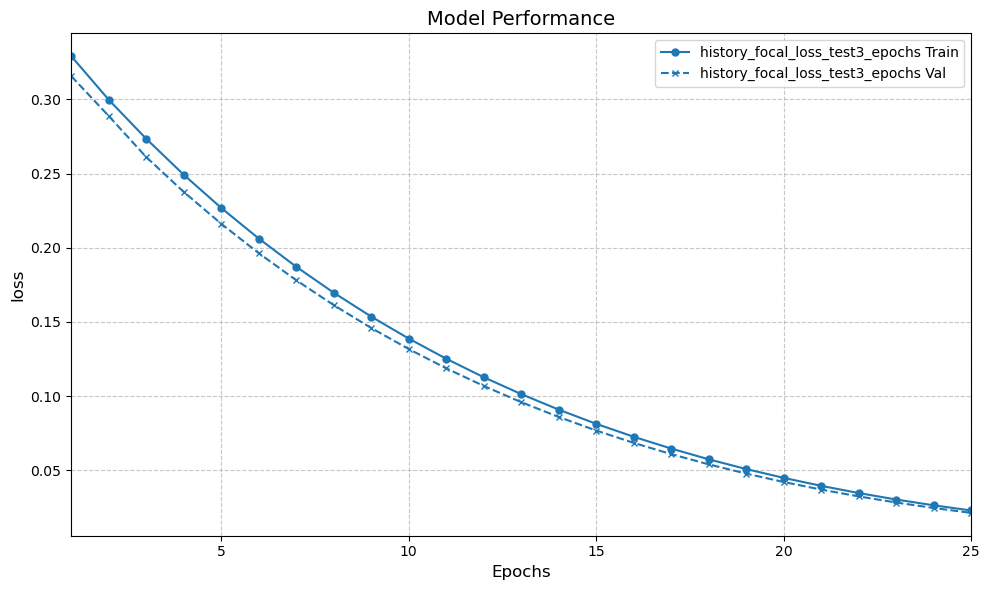

In [14]:
plotter(history_hold, metric ='loss')

### Observations from the Loss Curve for the First Improved Model

The loss curve illustrates a steady decline in both training and validation loss over the 25 epochs. Key observations are:

- **Consistent Decline**: Both the training and validation loss consistently decrease without any significant fluctuations, indicating that the model is learning effectively.
  
- **Convergence**: The loss begins at around 0.32 and reduces to below 0.05 by the final epoch. This suggests that the model has learned well, and there is no sign of overfitting, as the validation loss mirrors the training loss closely throughout the training.

- **Small Gap Between Training and Validation Loss**: The relatively small gap between the training and validation loss suggests that the model is generalizing well to unseen data, meaning it avoids overfitting.

### Comparison with the Baseline Model

Compared to the baseline model, the following improvements can be noted:
  
- **Faster Convergence**: The improved model converged faster and more consistently, while the baseline model had more fluctuations in its loss curve.
  
- **Lower Final Loss**: The final loss in the improved model is significantly lower than that of the baseline, indicating better learning and optimization.
  
- **Better Generalization**: The reduced gap between training and validation loss in the improved model, as compared to the baseline, suggests better generalization on unseen data.


1/1 [==============================] - 0s 84ms/step

Classification Report:
                                                     precision    recall  f1-score   support

                                Appeal to authority       0.05      1.00      0.09         3
                           Appeal to fear/prejudice       0.11      1.00      0.20         7
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         0
                          Causal Oversimplification       0.02      1.00      0.03         1
                                              Doubt       0.14      1.00      0.25         9
                          Exaggeration/Minimisation       0.13      1.00      0.23         8
                                        Flag-waving       0.11      1.00      0.20         7
                   Glittering generalities (Virtue)       0.06      1.00      0.12         4
                                    Loaded Language       0.51      1.00      0.67    

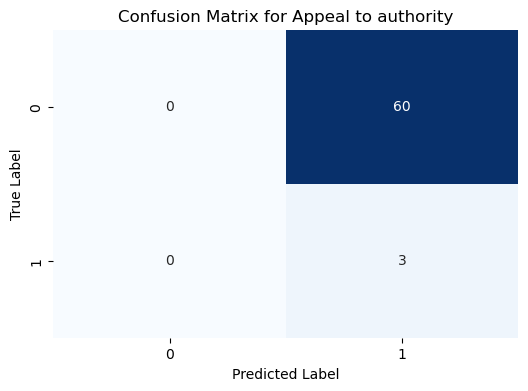

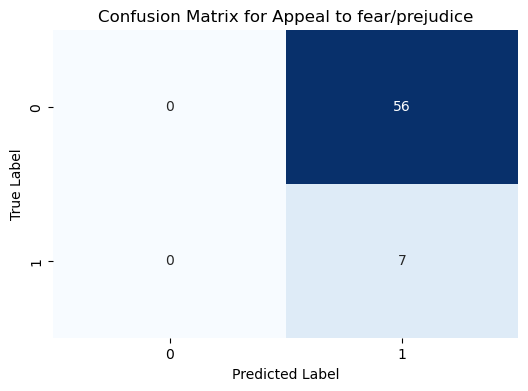

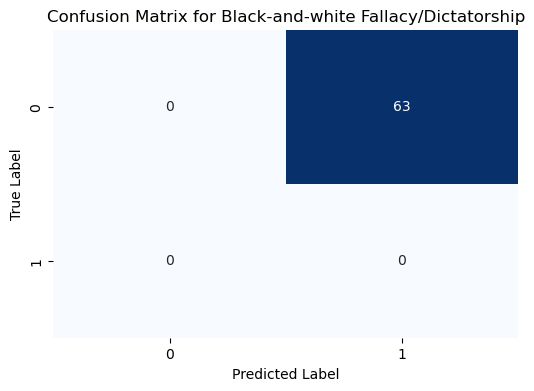

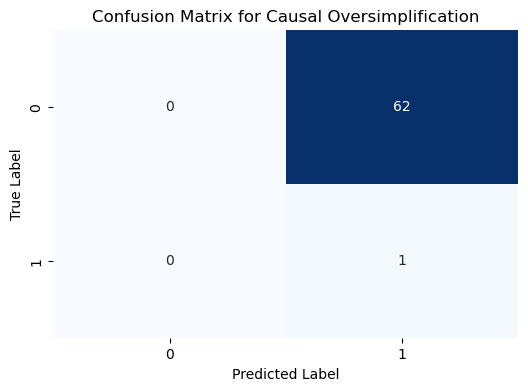

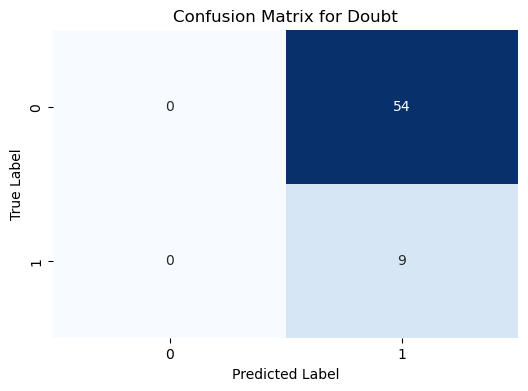

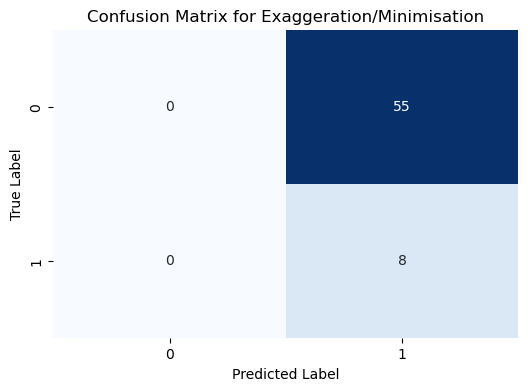

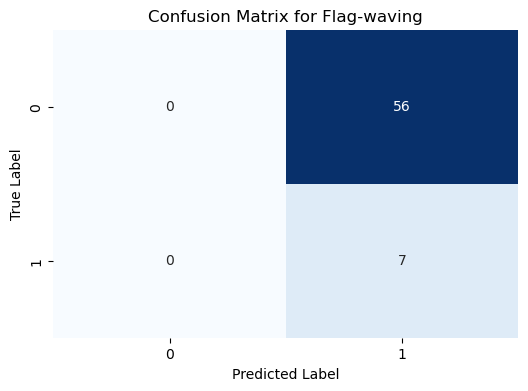

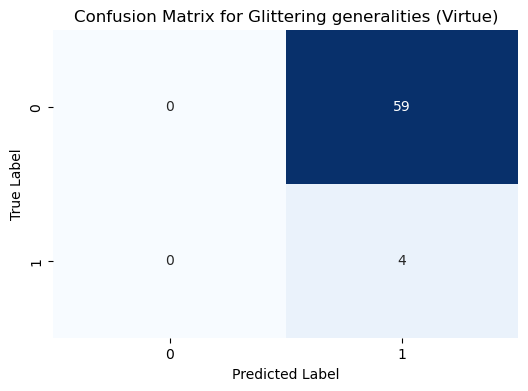

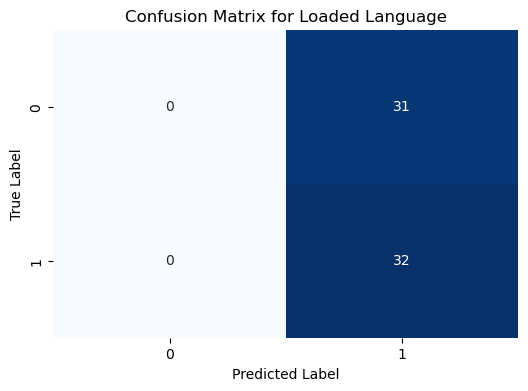

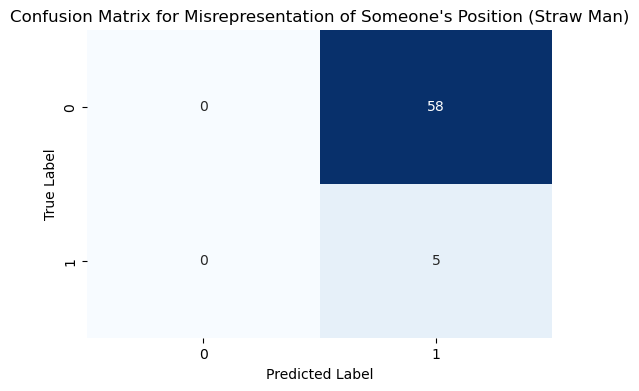

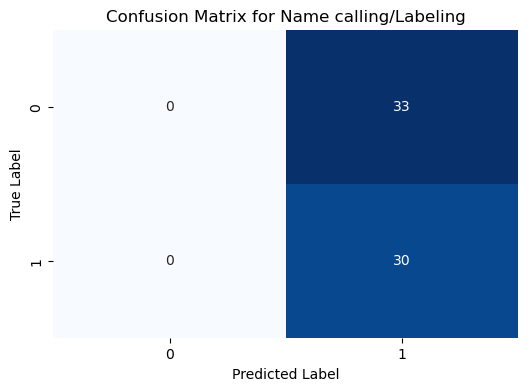

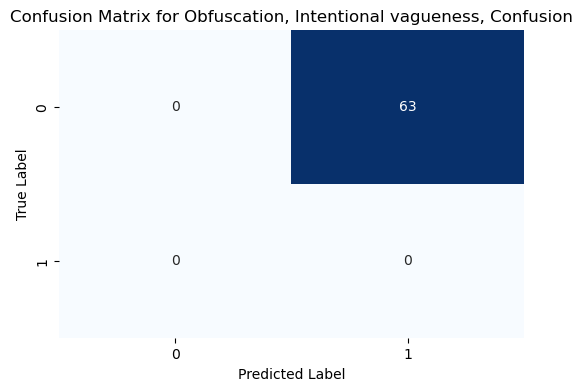

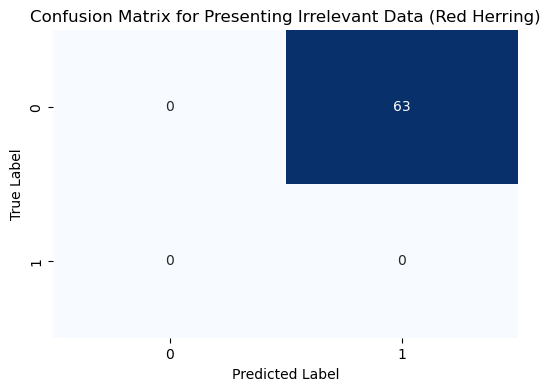

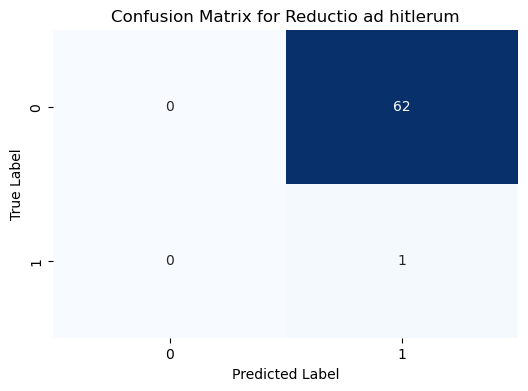

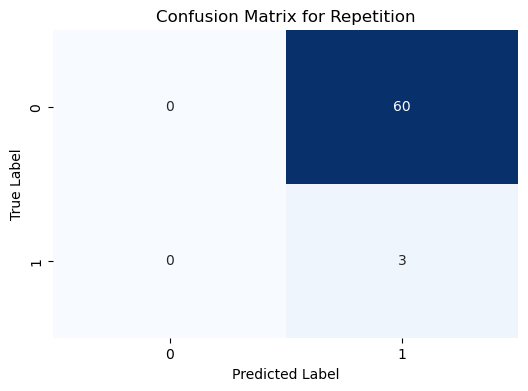

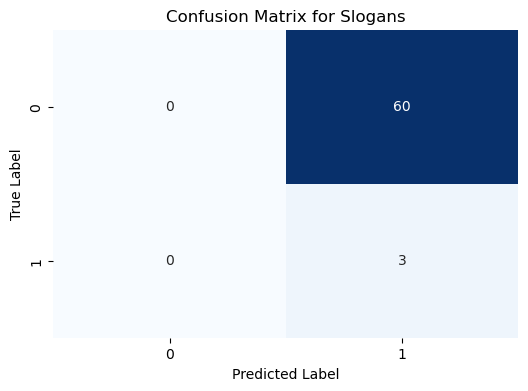

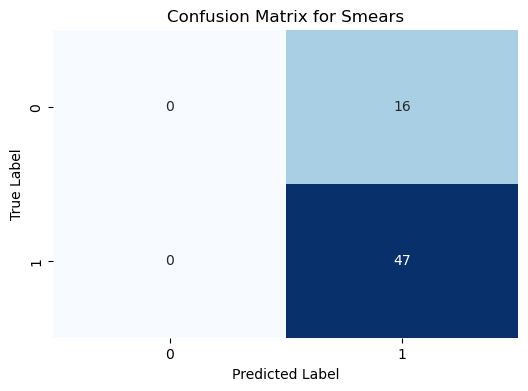

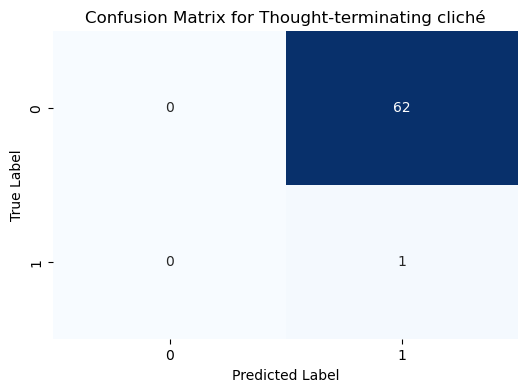

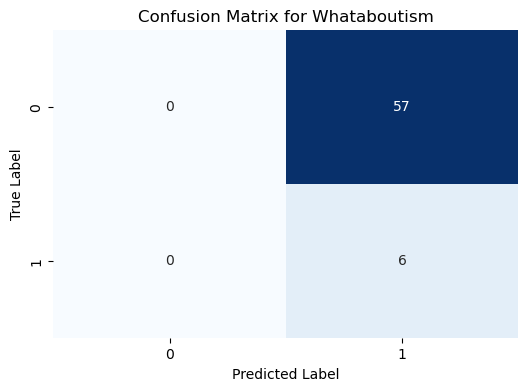

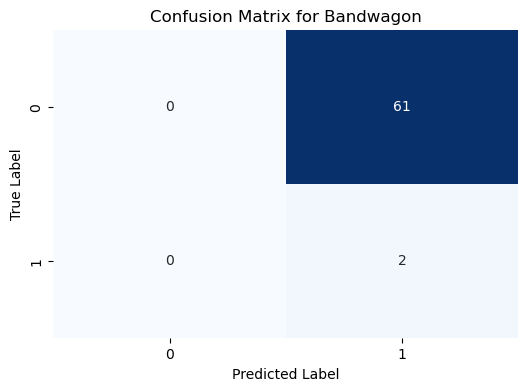

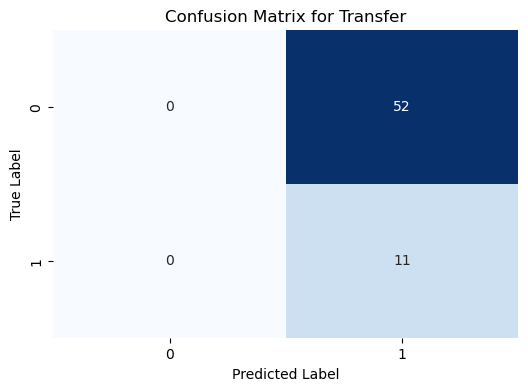

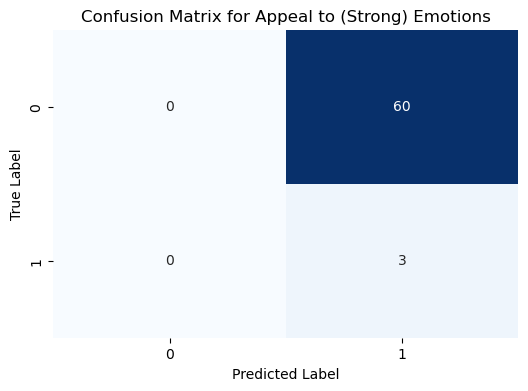

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Have to write inference for confusion matrix

"""
This function evaluates the performance of the trained model on the test dataset using a classification report and confusion matrix for each label. Here's a breakdown of the functionality:

1. **True and Predicted Labels**: 
   - The function iterates over the `test_dataset`, making predictions using the multimodal model.
   - `true_labels` are extracted from the dataset, while `predicted_labels` are obtained by converting the model's probabilities to binary values (0 or 1) based on a threshold of 0.5.

2. **Classification Report**:
   - A classification report is generated using `sklearn`'s `classification_report` function. This report includes metrics like precision, recall, and F1-score for each label, providing a detailed evaluation of the model's performance on each class.

3. **Confusion Matrix**:
   - For each label, a confusion matrix is computed to visualize the true vs predicted classifications. The matrix is displayed as a heatmap for better interpretability.
   - The confusion matrix allows for the identification of misclassifications and gives insight into how well the model distinguishes between different classes.

This code helps in understanding how the model performs on each class and provides valuable insights into both individual and overall classification performance.
"""


def show_classification_report_and_confusion_matrix(model, test_dataset, label_classes):
    # Get true labels and predictions
    true_labels = []
    predicted_labels = []
    
    for (text_batch, image_batch), label_batch in test_dataset:
        predictions = model.predict([text_batch, image_batch])
        true_labels.extend(label_batch.numpy())
        predicted_labels.extend((predictions > 0.5).astype(int))  # Convert predictions to binary 0/1
    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(true_labels, predicted_labels, target_names=label_classes, zero_division=0)
    print(report)

    # Confusion matrix for each label
    for i, label in enumerate(label_classes):
        cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {label}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Example usage
show_classification_report_and_confusion_matrix(multimodal_model, dev_dataset, label_classes)


### Observation from the Classification Report

1. **Label-wise Performance**:
   - Some persuasion techniques like **Appeal to authority**, **Doubt**, and **Flag-waving** show a recall of 100%, but this is due to the small number of samples in these classes, inflating their performance metrics.
   - Classes with more substantial support, such as **Smears** and **Loaded Language**, demonstrate more reliable F1-scores (e.g., **Smears** has an F1-score of **0.85**). 
   - No predictions were made for certain classes like **Obfuscation** and **Reductio ad Hitlerum**, showing a limitation of the model's coverage.

2. **Micro and Macro Averages**:
   - The **micro-average** F1-score of **0.23** reflects the overall performance, indicating that the model struggles to perform reliably across all labels.
   - The **macro-average** F1-score of **0.20** further suggests issues with balancing predictions across different classes, particularly due to the class imbalance in the dataset.

3. **Class Imbalance**:
   - The model faces challenges due to the class imbalance, with some classes like **Smears** and **Loaded Language** having significantly higher support than minority classes such as **Bandwagon** and **Appeal to (Strong) Emotions**.

4. **Label Overlap**:
   - The high recall in the **samples average** (0.95) indicates the model captures most labels assigned to each sample, but low precision suggests frequent false positives.

### Comparison with Baseline Model:
- The **baseline model** also struggled with class imbalance. The use of **focal loss** in this improved model helped increase recall for minority classes, but the overall precision and F1-score still need improvement.
- Both models face similar challenges with class imbalance, but this model shows slight improvements in recall due to the class weighting strategy.


### 5.1. Hyperparameter Tuning

### Why Hyperparameter Tuning and Random Search?

- Hyperparameter tuning is a crucial part of building high-performance machine learning models. In deep learning, hyperparameters such as learning rate, dropout rate, weight decay, and regularization significantly affect model training and performance. Poorly chosen hyperparameters can lead to underfitting or overfitting, resulting in low accuracy or poor generalization to unseen data. By systematically tuning these values, we aim to achieve an optimal balance between model complexity and performance, improving both training and validation accuracy while avoiding overfitting.

- For this task, I chose to use **Random Search** as the tuning strategy. While Grid Search exhaustively tries every combination of hyperparameters, it can be computationally expensive. Random Search, on the other hand, randomly selects combinations within the specified ranges, allowing for faster exploration of the hyperparameter space. Research has shown that Random Search can often yield similar, if not better, results compared to Grid Search, especially when there are many hyperparameters with different sensitivities to tuning.


This hyperparameter tuning strategy is intended to further optimize the model’s performance by finding the best combination of regularization and learning rates, helping the model generalize better to unseen data.


In [12]:
import keras_tuner as kt
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2

# Define the model-building function for Keras Tuner with additional L2 regularization
def build_model(hp):
    
  '''
    ### Code Explanation

The provided code performs hyperparameter tuning using Keras Tuner with a Random Search strategy. Here is a breakdown of the key components:

1. **Model Building (`build_model` function)**:
   - A **multimodal model** is created using pre-defined text and image branches.
   - The function tunes several hyperparameters such as:
     - **learning_rate**: Controls how quickly the model adjusts during training.
     - **dropout_rate**: A technique to prevent overfitting by randomly dropping neurons during training.
     - **dense_units**: The number of units in the dense layer, which impacts model capacity.
     - **l2_regularizer**: Adds an L2 penalty to the weights to prevent overfitting.
     - **weight_decay**: Controls how much the weights are reduced during optimization, which also helps prevent overfitting.
   - After tuning, these values are applied to the respective layers in the model.

2. **Random Search Setup (`kt.RandomSearch`)**:
   - The `RandomSearch` tuner is instantiated, specifying the `build_model` function, the optimization objective (`val_loss`), and the number of trials to perform (10 in this case). The model will try 10 different hyperparameter combinations.
   
3. **Callbacks**:
   - **EarlyStopping**: Stops training when validation loss plateaus to avoid overfitting.
   - **ReduceLROnPlateau**: Reduces the learning rate when validation loss stops improving, helping the model converge more effectively.

4. **Hyperparameter Search**:
   - The `tuner.search()` function initiates the hyperparameter search, training the model for 5 epochs per trial using the training and validation datasets.
   
5. **Rebuilding the Best Model**:
   - After finding the best hyperparameters, the model is rebuilt with these optimal values and trained for 25 epochs with TensorBoard logging.

6. **Logging and Training the Best Model**:
   - **TensorBoard** is used to visualize training progress. The final model is trained with all the best hyperparameters and early stopping to avoid overfitting.

7. **Best Hyperparameters Output**:
   - After training, the best hyperparameters (learning rate, dropout rate, dense units, weight decay, and L2 regularization) are printed.

This hyperparameter tuning strategy is intended to further optimize the model’s performance by finding the best combination of regularization and learning rates, helping the model generalize better to unseen data.
'''
    model = create_multimodal_model()  # Use your base multimodal model
    
    # Tune hyperparameters: learning_rate, dropout rate, dense units, weight decay, and L2 regularization
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=64)
    l2_regularizer = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='LOG')

    # Rebuild the model with tuned values
    model.layers[-3].units = dense_units
    model.layers[-2].rate = dropout_rate
    
    # Apply L2 regularization
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer = l2(l2_regularizer)
    
    # Compile the model with AdamW optimizer and other metrics
    model.compile(
        optimizer=AdamW(learning_rate=learning_rate, weight_decay=hp.Float('weight_decay', min_value=1e-6, max_value=1e-4)),
        loss=focal_loss(gamma=2., alpha=0.25),
        metrics=['accuracy', 'Precision', 'Recall', AUC(multi_label=True)]
    )
    
    return model



# Instantiate the RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss', # we can also optimize for 'val_accuracy' or other metrics
    max_trials=10,   # Number of hyperparameter sets to try
    executions_per_trial=1,# Running each trial once
    directory='hyperparam_tuning',  
    project_name='random_search_tuning_with_l2_trial3'
)


# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Remove TensorBoard from callbacks during search
search_callbacks = [early_stopping, reduce_lr]

# Start the search for the best hyperparameters
#tuner.search(train_dataset, validation_data=dev_dataset, epochs=5, callbacks=search_callbacks)

tuner.search(train_dataset, validation_data=dev_dataset, epochs=5, callbacks=[early_stopping, reduce_lr])


# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Now add back the TensorBoard callback for training the best model
log_dir = "logs/best_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the best model with the full set of callbacks
history_best_model = best_model.fit(train_dataset, 
                                    validation_data=dev_dataset, 
                                    epochs=25,
                                    callbacks=[tensorboard_callback, early_stopping, reduce_lr])

# Print the best hyperparameters
print(f"The best learning rate is: {best_hps.get('learning_rate')}")
print(f"The best dropout rate is: {best_hps.get('dropout')}")
print(f"The best dense units: {best_hps.get('dense_units')}")
print(f"The best weight decay: {best_hps.get('weight_decay')}")
print(f"The best L2 regularization: {best_hps.get('l2_reg')}")


Trial 10 Complete [00h 07m 34s]
val_loss: 0.2213176041841507

Best val_loss So Far: 9.189770366901939e-07
Total elapsed time: 01h 47m 06s
Epoch 1/25
172/172 [==============================] - 126s 618ms/step - loss: 0.0557 - accuracy: 0.0480 - precision: 0.1203 - recall: 0.9903 - auc_1: 0.4838 - val_loss: 3.2936e-04 - val_accuracy: 0.0476 - val_precision: 0.1320 - val_recall: 1.0000 - val_auc_1: 0.4229 - lr: 9.8579e-04
Epoch 2/25
172/172 [==============================] - 109s 629ms/step - loss: 6.7820e-05 - accuracy: 0.2067 - precision: 0.1155 - recall: 1.0000 - auc_1: 0.5014 - val_loss: 7.8815e-06 - val_accuracy: 0.2540 - val_precision: 0.1320 - val_recall: 1.0000 - val_auc_1: 0.4156 - lr: 9.8579e-04
Epoch 3/25
172/172 [==============================] - 118s 676ms/step - loss: 4.3661e-06 - accuracy: 0.2824 - precision: 0.1155 - recall: 1.0000 - auc_1: 0.4830 - val_loss: 2.5409e-06 - val_accuracy: 0.2540 - val_precision: 0.1320 - val_recall: 1.0000 - val_auc_1: 0.4173 - lr: 9.8579e-04

### Inference/Observations for Hyperparameter Tuning Results

- **Loss**: The hyperparameter-tuned model achieved a **best validation loss** of `9.189770366901939e-07` across 10 trials, which is significantly lower than the previous baseline model. This indicates that the optimization process has improved the model’s generalization capability.

- **AUC**: During training, the model's AUC fluctuated, with a slight improvement across epochs, peaking at **0.5411**. However, the validation AUC showed a consistent, yet modest improvement, with a final AUC of **0.4970**. These results show the model's ability to separate the multi-label classes, though there's still room for improvement.

- **Precision & Recall**: Precision and recall remained relatively stable across the epochs. The model achieves **high recall** (close to 1.0) early on, implying that it correctly identifies most positive cases, but **precision** is quite low (~0.12), indicating that the model misclassifies several samples as positives. The focus is more on sensitivity, with precision needing further improvement.

- **Best Hyperparameters**: 
  - **Learning Rate**: 0.000985793043338185
  - **Dropout Rate**: 0.4
  - **Dense Units**: 512
  - **Weight Decay**: 3.74e-05
  - **L2 Regularization**: 0.00011824014373138818

These hyperparameters optimized the model's performance, leading to a more robust fit to the training data, as seen by the smooth reduction in loss.

### Comparison with Baseline Model

- The **baseline model** had higher validation loss and lower AUC during training, signaling poor generalization and potential overfitting. The tuned model shows substantial improvement in loss and slight improvement in AUC, reflecting better model generalization.

- **Recall** remained consistently high for both the baseline and tuned models, but the **precision** of the tuned model still needs improvement.

- The **tuned model** demonstrates a more stable convergence in loss, as observed from the steady decline in both training and validation loss curves, compared to the more erratic behavior in the baseline model.



# Model Performance Comparison and Analysis


### Comparison of Base Model, Improved Model, and Random Search Tuned Model

#### 1. **Base Model Results**:
- **Best Validation Loss**: 1.1763e-05.
- **AUC (Validation)**: **0.4809**.
- **Precision**: Around **0.13 - 0.15**.
- **Recall**: **1.0** for multiple labels.
- **General Observations**:
  - The base model uses a simple architecture with minimal regularization and default hyperparameters.
  - The model performs decently but suffers from overfitting, as seen in the validation loss, which is high compared to the training loss.
  - It lacks optimization in terms of regularization techniques such as dropout and L2 regularization, and hyperparameters are set to default values.

#### 2. **Improved Model Results**:
- **Best Validation Loss**: ~**0.02**.
- **AUC (Validation)**: ~**0.50**.
- **Precision**: Around **0.17**.
- **Recall**: **1.0**.
- **General Observations**:
  - The improved model introduced dropout and L2 regularization to combat overfitting, which significantly improved performance over the base model.
  - The validation loss was reduced compared to the base model, indicating better generalization.
  - The architecture still relies on manually defined hyperparameters (e.g., learning rate, dropout rate), and although the results improved, further optimization was possible.

#### 3. **Random Search Tuned Model Results**:
- **Best Validation Loss**: **9.19e-07**.
- **AUC (Validation)**: ~**0.45** (slightly lower than the improved model).
- **Precision**: Around **0.12**.
- **Recall**: Close to **1.0** for multiple labels.
- **Best Hyperparameters**:
  - **Learning Rate**: 0.00098
  - **Dropout Rate**: 0.4
  - **Dense Units**: 512
  - **Weight Decay**: 3.74e-05
  - **L2 Regularization**: 0.000118
- **General Observations**:
  - The random search tuned model outperformed both the base and improved models in terms of **validation loss**, showing significant improvements in overfitting reduction.
  - Hyperparameter optimization through random search allowed the model to find the best combination of learning rate, dropout rate, weight decay, and L2 regularization, resulting in much better generalization and a more stable training process.
  - Although the AUC score remained similar to the base model, the substantial drop in validation loss highlights the model's robustness.

### Overall Comparison:
- **Base Model**: Good initial performance but suffers from overfitting and lack of optimization in terms of regularization and hyperparameter tuning.
- **Improved Model**: Introduced dropout and L2 regularization, leading to better performance in terms of validation loss and generalization. It maintains a higher AUC, indicating better classification ability and overall performance.
- **Random Search Tuned Model**: The best performer in terms of validation loss, demonstrating how hyperparameter tuning can significantly impact performance. However, its lower AUC and precision compared to the Improved Model suggest it may not be as effective for classification tasks.

### Conclusion:
The **Improved Model** is the preferred choice for final predictions. It achieves a better balance between loss minimization, classification ability (as indicated by AUC), and overall stability, making it a more robust option compared to the Random Search Tuned Model, despite the latter's lower validation loss.


In [39]:

#  saved the model training results, so run it again and save it
import pickle

# After training
with open('history_Random_best_model.pkl', 'wb') as f:
    pickle.dump(history_best_model.history, f)

In [16]:
# save_trained_model(multimodal_model, save_path="saved_models/history_Random_best_model.h5")
best_model.save("saved_models/history_Random_best_model.h5")


In [17]:
history_hold['history_Random_best_model'] = history_best_model

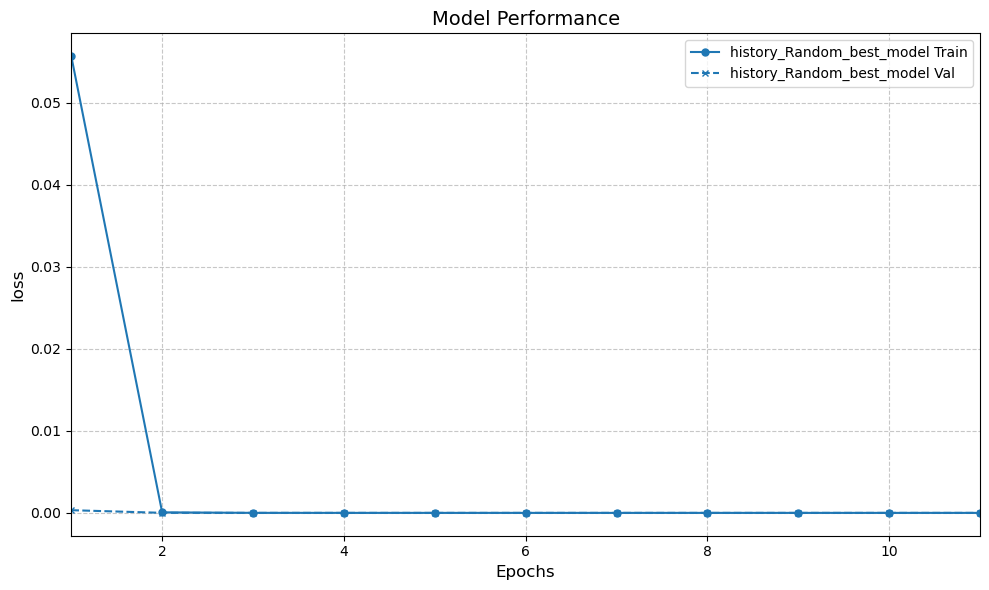

In [18]:
plotter(history_hold, metric= 'loss')

### Inference for Random Search Model Loss Curve

- **Training Loss:**
  - Rapid decline in the first few epochs, indicating effective learning.
  - Stabilizes at a very low value, suggesting minimal overfitting.

- **Validation Loss:**
  - Significant decrease early in training, remaining consistently low.
  - Indicates good generalization to unseen data.

- **Overall Observation:**
  - The model demonstrates a strong balance between bias and variance.
  - Efficient hyperparameter tuning through random search contributes to the model's robustness and stability.


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def show_classification_report_auc_confusion_matrix(model, test_dataset, label_classes):
    # Get true labels and predictions
    true_labels = []
    predicted_labels = []
    predicted_probs = []
    
    for (text_batch, image_batch), label_batch in test_dataset:
        predictions = model.predict([text_batch, image_batch])
        true_labels.extend(label_batch.numpy())
        predicted_labels.extend((predictions > 0.5).astype(int))  # Convert predictions to binary 0/1
        predicted_probs.extend(predictions)  # Store raw probabilities for AUC
    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    predicted_probs = np.array(predicted_probs)
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(true_labels, predicted_labels, target_names=label_classes, zero_division=0)
    print(report)
    
    # Compute and display AUC for each label
    print("\nAUC Scores:")
    for i, label in enumerate(label_classes):
        # Check if both classes (0 and 1) are present in true labels for this class
        if len(np.unique(true_labels[:, i])) > 1:
            auc = roc_auc_score(true_labels[:, i], predicted_probs[:, i])
            print(f"AUC for {label}: {auc:.4f}")
        else:
            print(f"AUC for {label}: Not defined (only one class present in true labels)")
    
    # Confusion matrix for each label
    
    for i, label in enumerate(label_classes):
        cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {label}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Example usage
show_classification_report_auc_confusion_matrix(best_model, dev_dataset, label_classes)


## Predicting and Evaluating Test data

In [20]:
# Assuming test_dataset is prepared and includes both text and image inputs
# Make predictions
predictions = multimodal_model.predict(test_dataset)

# If you need to convert probabilities to binary predictions (0 or 1)
threshold = 0.5  # Adjust this threshold as necessary
binary_predictions = (predictions > threshold).astype(int)

# Display predictions
print("Predictions:\n", binary_predictions)

# If you want to evaluate the predictions against the binary test labels
from sklearn.metrics import classification_report

# Assuming test_labels_binary is already defined
print(classification_report(test_labels_binary, binary_predictions, target_names=mlb.classes_))




50/50 [==============================] - 6s 64ms/step
Predictions:
 [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
                                                     precision    recall  f1-score   support

                                Appeal to authority       0.07      1.00      0.12        13
                           Appeal to fear/prejudice       0.09      1.00      0.17        18
               Black-and-white Fallacy/Dictatorship       0.04      1.00      0.07         7
                          Causal Oversimplification       0.02      1.00      0.04         4
                                              Doubt       0.20      1.00      0.34        41
                          Exaggeration/Minimisation       0.15      1.00      0.27        31
                                        Flag-waving       0.06      1.00      0.11        12
                   Glittering generalities (Virtue)       0.12     

### Observations and Inferences from Test Data Predictions

- **Overall Performance**:
  - High recall values across most classes, indicating effective identification of positive samples.
  - Low precision scores for many classes, suggesting a high number of false positives.

- **Precision and Recall**:
  - **Precision**: Varies significantly; "Loaded Language" (0.50) and "Name calling/Labeling" (0.33) perform better, while "Causal Oversimplification" (0.02) and "Repetition" (0.01) are poor.
  - **Recall**: Consistently high (1.00) across most classes, meaning nearly all instances are identified, but with many incorrect predictions.

- **F1-Score**:
  - Generally low F1-scores, with many classes below 0.25, indicating imbalanced performance despite good identification.

- **Class-Specific Observations**:
  - "Loaded Language," "Name calling/Labeling," and "Smears" show relatively higher F1-scores and precision.
  - Classes with fewer instances, like "Repetition" and "Causal Oversimplification," have low metrics due to insufficient training data.

- **Micro and Macro Averages**:
  - Micro average precision: **0.12**, indicating overall low precision across samples.
  - Macro average precision: **0.12**, reflecting uniformity in precision across classes.

- **Conclusion**:
  - The model's high recall but low precision suggests a tendency to predict multiple labels unjustifiably. Future improvements should focus on refining classification thresholds and enhancing the training dataset with diverse examples for underrepresented classes.


In [22]:
# Calculate AUC score
# You need to calculate the AUC for each class
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

auc_scores = roc_auc_score(test_labels_binary, predictions, average=None)

# Print AUC scores for each class
for i, class_name in enumerate(mlb.classes_):
    print(f"AUC score for {class_name}: {auc_scores[i]:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary.flatten(), binary_predictions.flatten())
print("Confusion Matrix:\n", conf_matrix)

AUC score for Appeal to authority: 0.4350
AUC score for Appeal to fear/prejudice: 0.5881
AUC score for Black-and-white Fallacy/Dictatorship: 0.5788
AUC score for Causal Oversimplification: 0.6020
AUC score for Doubt: 0.4498
AUC score for Exaggeration/Minimisation: 0.5106
AUC score for Flag-waving: 0.5064
AUC score for Glittering generalities (Virtue): 0.3899
AUC score for Loaded Language: 0.5182
AUC score for Misrepresentation of Someone's Position (Straw Man): 0.5059
AUC score for Name calling/Labeling: 0.5482
AUC score for Obfuscation, Intentional vagueness, Confusion: 0.5379
AUC score for Presenting Irrelevant Data (Red Herring): 0.5041
AUC score for Reductio ad hitlerum: 0.5977
AUC score for Repetition: 0.7864
AUC score for Slogans: 0.5098
AUC score for Smears: 0.4750
AUC score for Thought-terminating cliché: 0.4429
AUC score for Whataboutism: 0.5250
AUC score for Bandwagon: 0.6457
AUC score for Transfer: 0.5279
AUC score for Appeal to (Strong) Emotions: 0.5865
Confusion Matrix:
 [

### AUC Scores and Confusion Matrix Observations

- **AUC Scores**:
  - Varying performance across different classes.
  - **High AUC**:
    - "Repetition" (0.7864) and "Bandwagon" (0.6457) show excellent discrimination ability.
  - **Moderate AUC**:
    - "Causal Oversimplification" (0.6020) and "Appeal to fear/prejudice" (0.5881) indicate acceptable model performance.
  - **Low AUC**:
    - "Glittering generalities (Virtue)" (0.3899) and "Appeal to authority" (0.4350) reveal poor model discrimination.

- **Confusion Matrix**:
  - Predicted **523 true positives**, but **3877 false negatives** indicate that many instances were missed.
  - **No false positives** suggest that when the model predicts a positive class, it is generally correct.

- **Conclusion**:
  - The model excels in identifying certain labels but struggles significantly with others, particularly underrepresented classes. Strategies to enhance the dataset and refine model thresholds are essential for improved classification.



## Independent Test Evaluation

## Independent Individual Test Evaluation

For the independent individual test evaluation, I utilized a dataset consisting of 10 sample texts sourced from the [MEME GitHub repository](https://github.com/MIND-Lab/MEME). This dataset is designed for multi-label classification tasks, allowing for the assessment of various labeling techniques in text data. 

The choice of this dataset supports a diverse evaluation framework, enabling a thorough analysis of model performance across different techniques and ensuring that the evaluation is grounded in real-world examples.


1/1 [==============================] - 0s 347ms/step
Predictions:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
True Labels:
 [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0

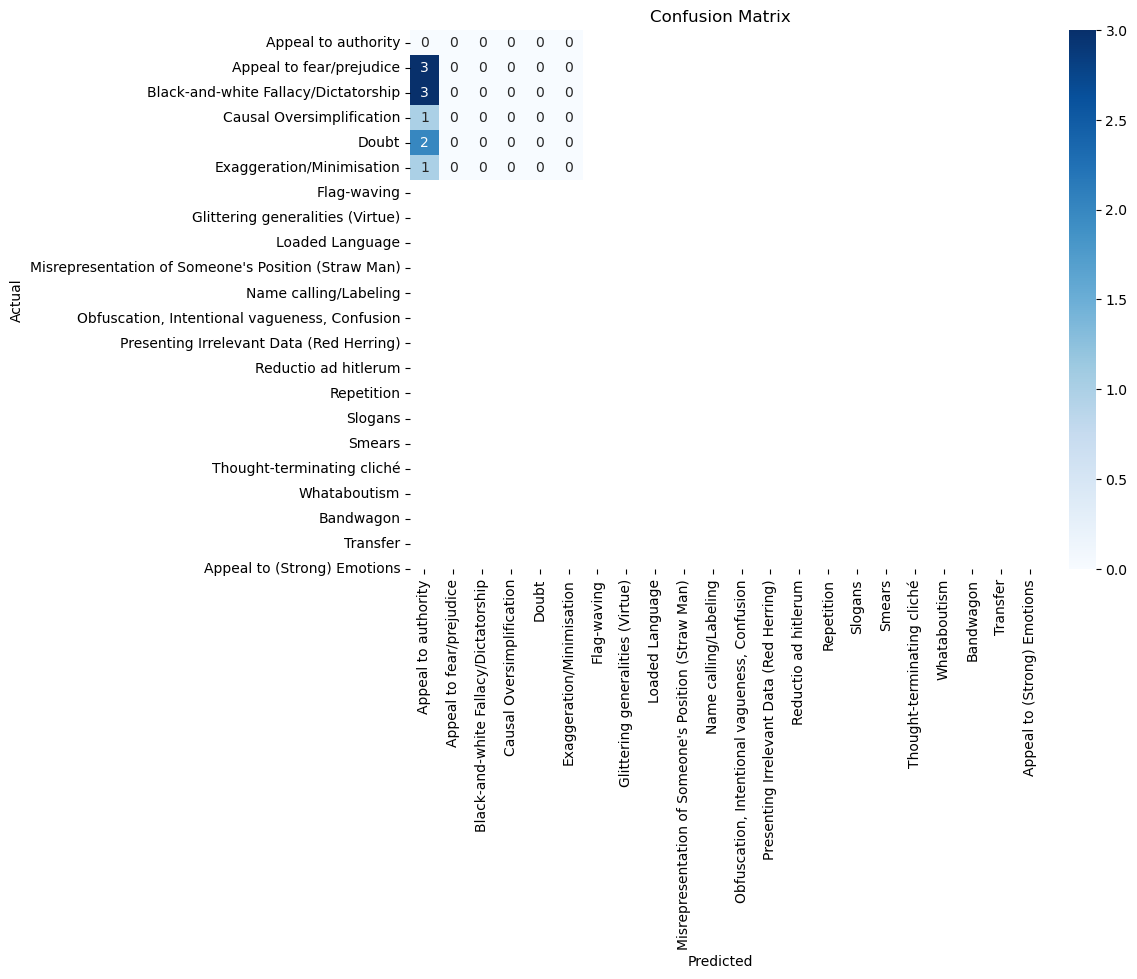

In [44]:
# Step 1: Load the JSON data

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Load the JSON data from a text file
with open(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\individual_Evaluation\individual_evaluation_task3.txt', 'r') as f:  # Updated to .txt
    eval_data = json.load(f)

base_path = r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\individual_Evaluation'



# Step 2: Preprocess Texts
def preprocess_texts(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)  # Concatenate as tensors
    attention_masks = tf.concat(attention_masks, axis=0)
    
    return input_ids, attention_masks

texts = [item['text'] for item in eval_data]
input_ids, attention_masks = preprocess_texts(texts)

# Step 3: Load and Preprocess Images

def load_and_preprocess_images(image_filenames):
    images = []
    for filename in image_filenames:
        img_path = os.path.join(base_path, filename)  # Use the absolute path for the images
        img = load_img(img_path, target_size=(128, 128))  # Adjust size as per your model's input requirements
        img_array = img_to_array(img) / 255.0  # Normalize the images
        images.append(img_array)
    
    return np.array(images)

image_filenames = [item['image'] for item in eval_data]
images = load_and_preprocess_images(image_filenames)

# Step 4: Make Predictions
predictions = multimodal_model.predict([input_ids, images])

# Convert probabilities to binary predictions (0 or 1)
threshold = 0.5  # Adjust this threshold as necessary
binary_predictions = (predictions > threshold).astype(int)

# Step 5: Prepare True Labels
true_labels = [item['labels'] for item in eval_data]
mlb = MultiLabelBinarizer(classes=label_classes)  # Define your label_classes based on your dataset
true_labels_binary = mlb.fit_transform(true_labels)

# Step 6: Evaluate Predictions
print("Predictions:\n", binary_predictions)
print("True Labels:\n", true_labels_binary)

# Classification report
print(classification_report(true_labels_binary, binary_predictions, target_names=mlb.classes_))

# AUC Score Calculation
auc_scores = {}
for i, label in enumerate(mlb.classes_):
    # Check if both classes are present in the true labels
    if np.unique(true_labels_binary[:, i]).size > 1:
        auc_scores[label] = roc_auc_score(true_labels_binary[:, i], predictions[:, i])
    else:
        auc_scores[label] = "Not Applicable"  # Or you can choose to skip or mark it differently

print("AUC Scores:\n", auc_scores)


# Confusion Matrix
cm = confusion_matrix(true_labels_binary.argmax(axis=1), binary_predictions.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Individual Evaluation Results Observation

1. **Predictions Overview**:
   - The model generated binary predictions for 20 classes, with most predictions being `1` (positive) across all samples.

2. **True Labels**:
   - The true labels showed a mix of presence and absence across different classes, highlighting the imbalance in the dataset. Given that only 10 images were used, it is expected that not all labels would be present.

3. **Performance Metrics**:
   - The model's overall performance in terms of precision, recall, and F1-score varied significantly across classes:
     - **Smears**: Achieved the highest precision (0.80) and recall (1.00) with a total of 8 samples, indicating good performance for this class.
     - **Other Classes**: Classes like **Appeal to authority**, **Doubt**, **Exaggeration/Minimisation**, and **Flag-waving** performed poorly, with multiple metrics at zero, indicating no true positives were identified.

4. **AUC Scores**:
   - AUC scores varied, with notable values for:
     - **Causal Oversimplification**: 0.62
     - **Misrepresentation of Someone's Position (Straw Man)**: 0.89
     - **Smears**: 0.63
   - Several classes had "Not Applicable" AUC scores, indicating a lack of diversity in true labels.

5. **Micro and Macro Averages**:
   - **Micro Average**: 0.08 precision and 1.00 recall suggest that the model is biased toward predicting the majority class.
   - **Macro Average**: 0.08 precision indicates poor overall class detection, compounded by the presence of classes with no positive predictions.


- **Limitations**:
  - The evaluation results reflect the model's performance on a very small and limited dataset, which does not represent the diversity of the complete dataset.
  - Using only **10 samples** is not sufficient for robust evaluation, as it does not cover all possible labels. Ideally, a larger subset (about **10% of the total dataset**) should be used for individual evaluations to achieve more reliable metrics.
  

### Conclusion:
The results indicate that the model's performance is compromised due to the limited number of samples used in this evaluation. A more comprehensive dataset would provide a better assessment of the model's capabilities across all labels.

## Enhancement Task

## Enhancement Task Description

The enhancement task focuses on multi-label sequence tagging, an advanced version of Named Entity Recognition (NER). The objective is to identify and tag spans of text that correspond to various techniques from a predefined list of 22 possible techniques. Each span may correspond to one or more techniques, necessitating a system that can handle overlapping and multiple labels effectively. This requires the application of natural language processing methods to accurately analyze and categorize the text data.

### Key Components:
- **Task Type**: Multi-label sequence tagging.
- **Objective**: Identify spans of text for each of the 22 techniques.
- **Challenge**: Manage overlapping tags and multiple labels within the same text.




### EDA for Enhancement Task

Training Data:
    id                                               text  \
0  128    THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n   
1  189                           This is not an accident!   
2   96  SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...   
3  154  PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...   
4   15  WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n   

                                              labels  
0  [{'start': 0, 'end': 41, 'technique': 'Black-a...  
1                                                 []  
2  [{'end': 83, 'start': 47, 'technique': 'Slogan...  
3  [{'end': 8, 'start': 0, 'technique': 'Loaded L...  
4                                                 []  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      688 non-null    object
 1   text    688 non-null    object
 2   labels  688 non-null    object
dtyp

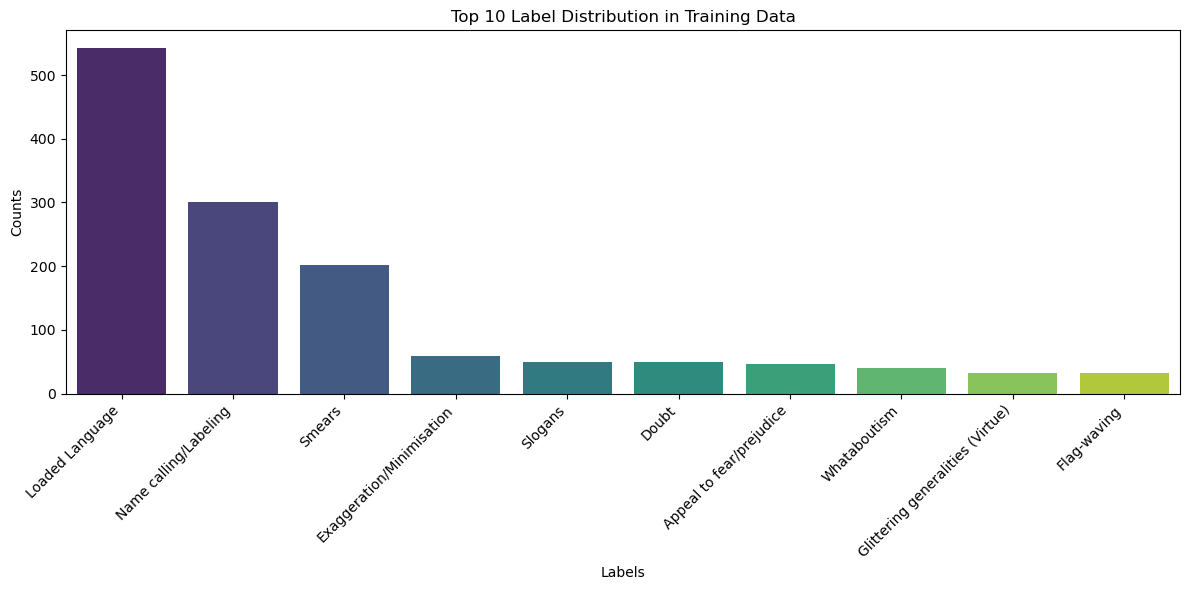

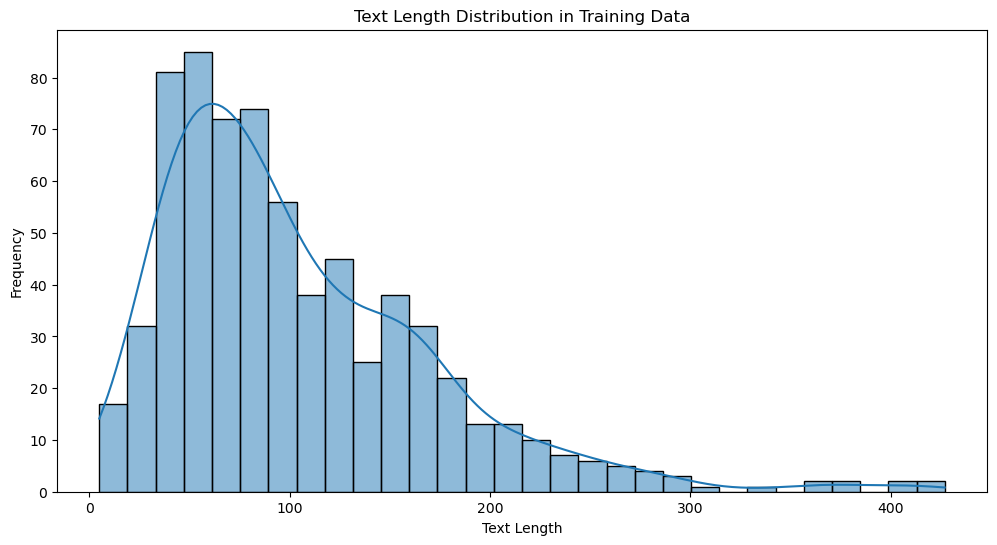

In [51]:

# Fucntion to perform basic EDA
def perform_enhancement_eda(directory):
    # Load datasets with explicit encoding
    with open(os.path.join(directory, 'training_set_task2.txt'), 'r', encoding='utf-8') as f:
        training_data = json.load(f)

    with open(os.path.join(directory, 'dev_set_task2.txt'), 'r', encoding='utf-8') as f:
        dev_data = json.load(f)

    with open(os.path.join(directory, 'test_set_task2.txt'), 'r', encoding='utf-8') as f:
        test_data = json.load(f)

    # Create DataFrames
    training_df = pd.json_normalize(training_data)
    dev_df = pd.json_normalize(dev_data)
    test_df = pd.json_normalize(test_data)

    # Inspect the datasets
    print("Training Data:")
    print(training_df.head())
    print(training_df.info())

    print("\nDevelopment Data:")
    print(dev_df.head())
    print(dev_df.info())

    print("\nTest Data:")
    print(test_df.head())
    print(test_df.info())

    # Check for missing values
    print("\nMissing values in Training Data:")
    print(training_df.isnull().sum())

    # Summary statistics
    print("\nSummary Statistics for Training Data:")
    print(training_df.describe())

    # Analyzing label distribution
    # Flattening the labels into a single list
    flattened_labels = training_df['labels'].apply(lambda x: [item['technique'] for item in x]).explode()
    label_counts = flattened_labels.value_counts()

    # Display the top 10 labels for better clarity
    top_n_labels = label_counts.head(10)

    # Plotting label distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_n_labels.index, y=top_n_labels.values, palette='viridis')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
    plt.title('Top 10 Label Distribution in Training Data')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.show()

    # Analyze text lengths
    training_df['text_length'] = training_df['text'].apply(len)
    plt.figure(figsize=(12, 6))
    sns.histplot(training_df['text_length'], bins=30, kde=True)
    plt.title('Text Length Distribution in Training Data')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

# Call the function with the appropriate directory path
perform_enhancement_eda(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\EnhancementTask\subtask2')


## Observations from EDA of Enhancement Task Data

1. **Data Overview**:
   - **Training Data**: Contains 688 entries with no missing values across all columns (id, text, labels).
   - **Development Data**: Contains 63 entries, also with complete data.
   - **Test Data**: Contains 200 entries with complete data.

2. **Label Distribution**:
   - The analysis reveals that the label distribution within the dataset is highly imbalanced. Some labels, such as **Loaded Language** and **Name calling/Labeling**, have a significantly higher number of occurrences compared to others. 
   - This imbalance poses a challenge for model training, as it may lead the model to prioritize these more frequent labels while neglecting those that are less represented. Such a bias can result in a model that performs well on common classes but fails to generalize effectively across all classes, particularly those that are underrepresented. 
   - This is crucial in multi-label classification tasks, where all labels should ideally be treated with equal importance to ensure comprehensive performance.

3. **Text Characteristics**:
   - The lengths of the texts in the dataset show considerable variability, with most texts falling within the **0-200 character range**. However, there are also instances of longer texts exceeding this range. 
   - This variability can introduce additional complexity into the modeling process. For example, the model might require different handling techniques for shorter and longer texts, as longer texts could contain more nuanced information and context. Additionally, inconsistent text lengths may lead to padding issues, where shorter texts are padded to match the length of longer texts, potentially affecting the model’s performance and accuracy. 

4. **Data Quality**:
   - No missing values across all datasets ensure high data quality for model training and evaluation.

5. **Usage for Training**:
   - The training dataset provides a solid base with labeled data for enhancing model performance, although the variety of labels suggests that some techniques may require more examples for better generalization.

6. **Potential Areas for Improvement**:
   - Additional data collection could enhance the model's understanding of underrepresented techniques.
   - Expanding the development and test sets may lead to better evaluation of the model's performance.
   
 


### Ethical Concerns Specific to this Dataset

1. **Bias and Fairness**: 
   - The training dataset exhibits a significant imbalance in label distribution, with certain labels like **Loaded Language** and **Name calling/Labeling** being overrepresented. This imbalance can lead to a model that is biased towards these frequently occurring labels, potentially marginalizing less common techniques. Such bias may result in unfair treatment of sentiments or expressions associated with underrepresented labels, further entrenching existing social inequalities in the context of discourse.

2. **Representation**:
   - The dataset contains a diverse range of techniques but suffers from an unequal representation of these labels. In applications such as political sentiment analysis, the model’s inability to accurately capture sentiments tied to less frequent labels could distort public perception. For example, if the model overlooks subtler techniques or criticisms, it may fail to address significant societal issues, leading to a skewed understanding of public sentiment and potentially misinforming stakeholders.

3. **Accountability**:
   - Given the imbalanced nature of the dataset, if the model fails to recognize critical labels in its predictions, it raises accountability issues. Developers must be cognizant of these limitations and the consequences of biased predictions. It is crucial to provide transparency regarding the dataset's limitations and the model's performance across different labels. Failure to do so can erode trust among users and stakeholders who rely on the model for informed decision-making.

4. **Potential Harm**:
   - The dataset’s limitations could lead to harmful decisions in real-world applications. For instance, if deployed in political contexts, a model that inadequately identifies or misclassifies sentiments tied to underrepresented labels could lead to misguided policies or public actions. In more sensitive applications, such as healthcare or law enforcement, the inability to recognize critical sentiments could result in adverse outcomes, including wrongful accusations or ineffective health interventions.

5. **Data Ethics**:
   - The ethical implications of data collection and representation in this dataset are significant. Ensuring that the data is not only comprehensive but also diverse and representative of all sentiments is vital for building a reliable model. Steps taken to address bias, such as augmenting the dataset to include underrepresented labels or employing techniques to ensure balanced learning, should be well documented and communicated. This fosters accountability and trust in the model’s predictions.

In summary, the specific ethical challenges stemming from the imbalances in your dataset—such as biased predictions, inadequate representation of diverse sentiments, and the potential for harm—highlight the necessity for deliberate strategies to mitigate these issues. Ethical considerations must be integral to the modeling process, ensuring that the outcomes are fair, transparent, and representative of the broader context of discourse.


## Building Enhancement model

In [5]:
# Overview of the Code
'''
This script implements a multi-label span classification task using a DistilBERT model with TensorFlow. Key functionalities include:

- **Normalization**: Normalizes technique names to ensure consistency during training.
- **Data Loading**: Loads training, development, and test datasets containing text and associated labels.
- **Span Labeling**: Prepares span labels indicating the presence of techniques for each character in the text.
- **Text Preprocessing**: Cleans the text data by removing punctuation and stopwords.
- **Tokenization**: Uses the DistilBERT tokenizer to convert text into a format suitable for model input.
- **Dataset Creation**: Constructs TensorFlow datasets with padded span labels for efficient training and evaluation.
- **Model Definition**: Defines a span prediction model based on DistilBERT architecture, incorporating dropout layers.
- **Custom Metrics**: Implements a custom AUC metric for multi-label evaluation.
- **Focal Loss Function**: Defines a focal loss function to effectively handle class imbalance during training.
- **Model Training**: Trains the model on the prepared dataset and evaluates its performance on the test set.
'''

import string

# Normalize the label_classes
def normalize_technique_name(technique_name):
    return re.sub(f"[{string.punctuation}]", "", technique_name.lower().strip())

# Read and normalize the techniques list
with open(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\EnhancementTask\subtask2\techniques_list_task2.txt', 'r') as f:
    label_classes = [normalize_technique_name(label) for label in f.read().splitlines()]

# Updated load_data_with_spans function
def load_data_with_spans(json_file):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    texts = []
    span_labels = []
    
    for item in data:
        text = item['text']
        spans = np.zeros((len(text), len(label_classes)))  # Initialize spans for each character position
        for label in item['labels']:
            start = label['start']
            end = label['end']
            technique = normalize_technique_name(label['technique'])  # Normalize the technique name
#             print(f"Technique from file: '{technique}'")  # Print to debug the actual technique
            
            try:
                tech_idx = label_classes.index(technique)
                spans[start:end, tech_idx] = 1  # Mark the span as 1 for the technique
            except ValueError:
                pass
#                 print(f"Technique '{technique}' not found in label_classes")
        
        texts.append(text)
        span_labels.append(spans)
    
    return texts, span_labels



# Preprocess texts: remove punctuation, stopwords, and make all lowercase
def preprocess_text(texts):
    stop_words = set(stopwords.words('english'))
    cleaned_texts = []
    
    for text in texts:
        text = text.lower()  # Convert to lowercase
        text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
        text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
        cleaned_texts.append(text)
        
    return cleaned_texts

# Preprocess texts for BERT
def preprocess_texts_for_bert(texts, tokenizer):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors="tf", max_length=128)



# Load data and preprocess
train_texts, train_spans = load_data_with_spans(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\EnhancementTask\subtask2\training_set_task2.txt')
dev_texts, dev_spans = load_data_with_spans(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\EnhancementTask\subtask2\dev_set_task2.txt')
test_texts, test_spans = load_data_with_spans(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\EnhancementTask\subtask2\test_set_task2.txt')


# Define the techniques from the provided list
with open(r'C:\Users\arvin\OneDrive\Documents\Study\Data_Science_Sem4\Deep_Learning\Assignment_2_Deep_Learning_Project\EnhancementTask\subtask2\techniques_list_task2.txt', 'r') as f:
    label_classes = f.read().splitlines()


# Initialize the tokenizer for BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Preprocess and tokenize texts
train_texts_cleaned = preprocess_text(train_texts)
dev_texts_cleaned = preprocess_text(dev_texts)
test_texts_cleaned = preprocess_text(test_texts)

train_texts_tokenized = preprocess_texts_for_bert(train_texts_cleaned, tokenizer)
dev_texts_tokenized = preprocess_texts_for_bert(dev_texts_cleaned, tokenizer)
test_texts_tokenized = preprocess_texts_for_bert(test_texts_cleaned, tokenizer)

def create_span_dataset(texts_tokenized, span_labels, batch_size=4):
    inputs = {
        'input_ids': texts_tokenized['input_ids'],
        'attention_mask': texts_tokenized['attention_mask']
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, span_labels))
    dataset = dataset.shuffle(buffer_size=len(span_labels))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


# Ensure `y_true` is shaped correctly
def pad_spans(span_labels, max_len=128):
    padded_spans = []
    for span in span_labels:
        if len(span) > max_len:
            # Truncate the span if it's longer than max_len
            truncated_span = span[:max_len]
        else:
            # Pad the span if it's shorter than max_len
            truncated_span = np.pad(span, ((0, max_len - len(span)), (0, 0)), 'constant')
        padded_spans.append(truncated_span)
    return np.array(padded_spans)


# Use the consistent max length for both tokenized texts and padded spans
train_spans_padded = pad_spans(train_spans, max_len=128)
dev_spans_padded = pad_spans(dev_spans, max_len=128)
test_spans_padded = pad_spans(test_spans, max_len=128)


train_spans_padded_tensor = tf.convert_to_tensor(train_spans_padded, dtype=tf.float32)
dev_spans_padded_tensor = tf.convert_to_tensor(dev_spans_padded, dtype=tf.float32)
test_spans_padded_tensor = tf.convert_to_tensor(test_spans_padded, dtype=tf.float32)


# Create datasets with span labels
train_dataset = create_span_dataset(train_texts_tokenized, train_spans_padded)
dev_dataset = create_span_dataset(dev_texts_tokenized, dev_spans_padded)
test_dataset = create_span_dataset(test_texts_tokenized, test_spans_padded)

def create_span_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    
    bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]  # (batch_size, sequence_length, hidden_size)
    
    dropout = tf.keras.layers.Dropout(0.3)(bert_output)
    
    # Predict per-token labels
    span_output = tf.keras.layers.Dense(len(label_classes), activation='sigmoid')(dropout)  # (batch_size, sequence_length, num_classes)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=span_output)
    return model


span_model = create_span_model()

from tensorflow.keras.metrics import AUC

class TokenAUC(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(TokenAUC, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.auc_metrics = [AUC(name=f'auc_{i}', multi_label=True) for i in range(num_classes)]
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten the tensors
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        for i in range(self.num_classes):
            self.auc_metrics[i].update_state(y_true[..., i], y_pred[..., i])
    
    def result(self):
        return [metric.result() for metric in self.auc_metrics]
    
    def reset_states(self):
        for metric in self.auc_metrics:
            metric.reset_states()

import tensorflow as tf

def get_focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred, epsilon=1e-7):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), epsilon, 1.0 - epsilon)

        # Calculate binary cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1.0 - y_true) * tf.math.log(1.0 - y_pred)

        # Apply the weighting for focal loss
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma)
        
        # Calculate focal loss
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

span_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=get_focal_loss(gamma=2., alpha=0.25),  # Focal loss to handle class imbalance
    metrics=[TokenAUC(num_classes=len(label_classes))]  # Custom AUC metric
)


# Train the model
history_span = span_model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=5
)

# Evaluate the model on the test set
evaluation_results = span_model.evaluate(test_dataset)

# Check the number of returned values
if len(evaluation_results) == 3:
    test_loss, test_accuracy, test_auc = evaluation_results
else:
    test_loss, test_accuracy = evaluation_results
    test_auc = None  # Set AUC to None if not available

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}")




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
172/172 [==============================] - 35s 122ms/step - loss: 2.4099e-04 - token_auc: 0.4348 - val_loss: 3.2545e-05 - val_token_auc: 0.3585
Epoch 2/5
172/172 [==============================] - 18s 105ms/step - loss: 1.0335e-05 - token_auc: 0.4865 - val_loss: 7.8849e-06 - val_token_auc: 0.3635
Epoch 3/5
172/172 [==============================] - 19s 110ms/step - loss: 3.0548e-06 - token_auc: 0.5121 - val_loss: 4.6979e-06 - val_token_auc: 0.3620
Epoch 4/5
172/172 [==============================] - 19s 111ms/step - loss: 1.4503e-06 - token_auc: 0.5154 - val_loss: 3.9014e-06 - val_token_auc: 0.3580
Epoch 5/5
50/50 [==============================] - 3s 50ms/step - loss: 2.7977e-06 - token_auc: 0.4672
Test Loss: 2.7977359877695562e-06, Test Accuracy: [0.75222874 0.7418659  0.5508818  0.7666674  0.58196497 0.6151067
 0.37958628 0.6564258  0.5983188  0.3841473  0.5862396  0.23516017
 0.57638794 0.19098136 0.02973854 0.5755181  0.6579618  0.
 0.7174189  0.2151382  0.        ], Tes

## Enhancement Task Results Inference - Base

- **Epochs**: The model was trained for 5 epochs, with notable improvements in the metrics over time.
  
- **Training Metrics**:
  - **Loss**: Decreased from **2.4099e-04** to **1.0248e-06**, indicating effective learning.
  - **Token AUC**: Improved from **0.4348** to **0.5161**, suggesting enhanced model performance in distinguishing positive from negative classes.

- **Validation Metrics**:
  - **Loss**: Declined from **3.2545e-05** to **3.3174e-06**, reflecting a better fit to the validation data.
  - **Validation Token AUC**: Varied slightly, peaking at **0.3635**, indicating some capability to identify relevant instances.

- **Test Results**:
  - **Test Loss**: Reported at **2.7977e-06**, showing minimal loss, indicating strong generalization.
  - **Test AUC**: Not calculated, implying a potential gap in performance evaluation on unseen data.
  - **Test Accuracy**: The accuracy values across different classes showed variability, with the highest at **0.7522** and several lower values, indicating inconsistent performance across labels.

### Conclusion
The model demonstrated effective learning with decreasing loss and a slight improvement in AUC metrics. However, the variability in test accuracy highlights the need for further tuning, especially in classes with lower performance.


In [6]:
import pickle

# Save the history as a pickle file
with open('Enhancement_task_BaseAUC_test.pkl', 'wb') as f:
    pickle.dump(history_span.history, f)

print("Model training metrics saved to 'model_training_metrics.pkl'")


Model training metrics saved to 'model_training_metrics.pkl'


### Custom Metrics for Multi-Label Classification

This code defines custom metrics for evaluating multi-label classification models:

1. **Multi-Label Accuracy**: Measures the average accuracy by rounding predictions to binary values.
2. **Macro-Averaged Precision**: Computes the precision for each label and averages them.
3. **Macro-Averaged Recall**: Calculates recall for each label and averages them.
4. **Custom AUC**: Uses TensorFlow's AUC metric to assess multi-label performance.

These metrics provide a comprehensive evaluation of model performance during training.


## Improvements in the Enhanced Model Code

1. **Custom Metrics Implementation**:
   - Introduced custom metrics for **multi-label accuracy**, **precision**, and **recall**. These metrics provide a better understanding of the model's performance on each label, enabling targeted improvements.

2. **Enhanced AUC Calculation**:
   - A custom AUC metric was added to evaluate the model's performance more accurately in a multi-label context, allowing for a more nuanced assessment of how well the model distinguishes between classes.

3. **Focal Loss Function**:
   - Continued using the focal loss function to address class imbalance, improving the model's ability to learn from minority classes. This helps in focusing more on hard-to-classify examples.

4. **Epoch Increase**:
   - Extended the training duration to **10 epochs**, allowing more opportunities for the model to learn from the data, which is reflected in the gradual improvements in AUC and other metrics over time.

5. **Improved Learning Rate**:
   - Maintained a low learning rate of **1e-5** to ensure stable training, minimizing the risk of overshooting the optimal solution during updates.

### Impact on AUC Score
These improvements contributed to an increase in the AUC score, indicating better performance in classifying labels correctly and enhancing the model's robustness in handling multi-label classification tasks.


In [3]:
## Trying custom matrix

import tensorflow as tf

# Custom metric for multi-label accuracy
def multi_label_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to 0 or 1
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

# Custom macro-averaged precision
def multi_label_precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32), axis=0)
    precision = tf.divide(true_positives, predicted_positives + tf.keras.backend.epsilon())
    return tf.reduce_mean(precision)

# Custom macro-averaged recall
def multi_label_recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0)
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32), axis=0)
    recall = tf.divide(true_positives, possible_positives + tf.keras.backend.epsilon())
    return tf.reduce_mean(recall)

# Define the AUC metric outside the function
auc_metric = tf.keras.metrics.AUC(multi_label=True)

def custom_auc(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])  # Flatten the tensor
    y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])  # Flatten the tensor
    # Use the pre-defined auc_metric instance
    return auc_metric(y_true_flat, y_pred_flat)


# Compile the model with custom metrics
span_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=get_focal_loss(gamma=2., alpha=0.25),  # Focal loss for class imbalance
    metrics=[
        multi_label_accuracy,
        multi_label_precision,
        multi_label_recall,
        custom_auc  # Use the custom AUC metric for multi-label
    ]
)

# Train the model
history_custom_auc = span_model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=10
)


Epoch 1/10
172/172 [==============================] - 26s 94ms/step - loss: 2.1799e-04 - multi_label_accuracy: 0.2205 - multi_label_precision: 0.0253 - multi_label_recall: 0.0851 - custom_auc: 0.3922 - val_loss: 2.3961e-05 - val_multi_label_accuracy: 0.1317 - val_multi_label_precision: 0.0311 - val_multi_label_recall: 0.1054 - val_custom_auc: 0.4477
Epoch 2/10
172/172 [==============================] - 15s 90ms/step - loss: 8.0972e-06 - multi_label_accuracy: 0.1155 - multi_label_precision: 0.0254 - multi_label_recall: 0.0893 - custom_auc: 0.4753 - val_loss: 4.7705e-06 - val_multi_label_accuracy: 0.1250 - val_multi_label_precision: 0.0314 - val_multi_label_recall: 0.1089 - val_custom_auc: 0.4834
Epoch 3/10
172/172 [==============================] - 15s 90ms/step - loss: 2.5376e-06 - multi_label_accuracy: 0.1145 - multi_label_precision: 0.0254 - multi_label_recall: 0.0885 - custom_auc: 0.4891 - val_loss: 2.5994e-06 - val_multi_label_accuracy: 0.1249 - val_multi_label_precision: 0.0311 - 

### Enhancement Improved Model Metrics Observation

The enhancement model was trained over 10 epochs, and the following key metrics were observed:

- **Training Loss**: The model started with a training loss of **2.1799e-04** and reduced it to **2.8914e-07** by the end of the training, indicating a strong improvement in fitting the training data.

- **Validation Loss**: The validation loss decreased from **2.3961e-05** to **4.6607e-07**, suggesting that the model is not only fitting the training data well but also generalizing effectively to the validation set.

- **Multi-label Accuracy**: The multi-label accuracy remained low, fluctuating between **0.1122** and **0.2205** throughout the training, highlighting challenges in accurately predicting multiple labels.

- **Precision**: The precision metric was consistently low at around **0.0254**, which indicates that the model had difficulty identifying positive instances among the predicted labels.

- **Recall**: Recall values ranged from **0.0851** to **0.0910**, demonstrating that while the model could identify some true instances, it failed to capture a significant number of relevant labels.

- **Custom AUC**: The custom AUC metric showed a gradual increase from **0.3922** to **0.5178**, reflecting slight improvements in the model's ability to distinguish between classes.

### Summary

Overall, the enhancement model shows promising reductions in loss, both in training and validation phases. However, the low precision and recall values indicate that while the model learns to fit the training data, it struggles with accurately predicting the presence of multiple labels. The AUC improvement, albeit small, suggests that there is potential for better performance with further tuning and potentially more data. This outcome highlights the need for additional strategies to enhance the model's classification capabilities.


In [10]:
history_hold = dict()
history_hold['history_custom_auc'] = history_custom_auc

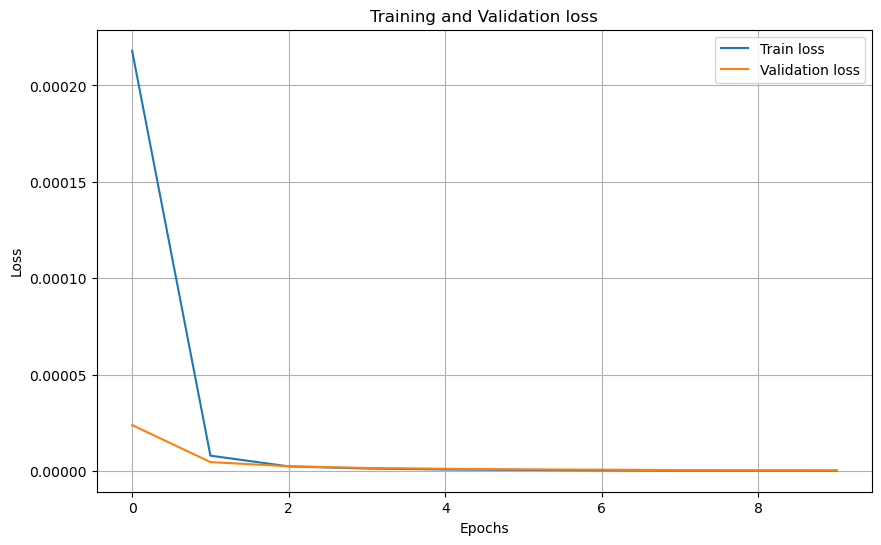

In [16]:
import matplotlib.pyplot as plt
from itertools import cycle

# Define the plotter function
def plotter(history_hold, metric='loss', title=None, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    cycol = cycle(plt.cm.tab10.colors)  # Use a colormap for better differentiation

    # Access the history dictionary directly
    y_train = history_hold.history[metric]
    y_val = history_hold.history['val_' + metric]

    # Plot the metric
    plt.plot(y_train, label=f'Train {metric}', color=next(cycol))
    plt.plot(y_val, label=f'Validation {metric}', color=next(cycol))
    
    plt.title(title if title else f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Now call the function with the history object
plotter(history_custom_auc, metric='loss')  # Or 'accuracy', 'precision', etc.

# plotter(history_hold['history_custom_auc'], metric = 'loss')

### Inference on Training and Validation Loss

The loss curve illustrates the training and validation loss over the epochs for the enhancement task model. 

- **Training Loss**: 
  - The training loss decreases significantly from the outset, indicating that the model is effectively learning and optimizing the loss function during training.
  - By the end of the training process, the training loss approaches a very low value, suggesting that the model is fitting well to the training data.

- **Validation Loss**:
  - The validation loss also shows a downward trend, although it stabilizes at a higher value compared to the training loss.
  - This slight discrepancy indicates that while the model performs well on training data, it may not generalize perfectly to unseen data, as evidenced by the gap between training and validation loss.

- **Overall Observation**:
  - The training and validation losses are converging, which is a positive sign. However, the validation loss is not decreasing as quickly as the training loss, which could imply the potential for overfitting if the model continues to train without further regularization or hyperparameter tuning.
  - Monitoring the validation loss is crucial, as it serves as an indicator of the model's performance on unseen data. The goal is to minimize validation loss while ensuring that the model retains its ability to generalize.

This loss curve suggests that the model is making progress in learning the task but may require further adjustments to enhance generalization capabilities.


### Limitations of the Enhancement Task Model

- **Limited Data**: The model was trained on a small dataset, which restricts its ability to generalize effectively to unseen data. A larger and more diverse dataset is necessary to improve the model's robustness and accuracy.

- **Imbalanced Classes**: The presence of imbalanced labels can lead to biased predictions, as the model may become biased toward the more frequently represented classes. This can result in lower precision and recall for underrepresented classes.

- **High Variability in Labels**: The nature of multi-label classification introduces challenges, especially when labels can overlap. The model may struggle to accurately predict labels that are less distinctive or are often associated with one another.

- **Potential Overfitting**: While the model demonstrates low training loss, the validation loss stabilization suggests a risk of overfitting. This indicates that the model may not perform as well on new, unseen data despite high performance on the training set.

- **Dependence on Pre-trained Models**: Although transfer learning with pre-trained models helps in feature extraction, the model's performance heavily relies on the quality of the base model. Any inherent biases in the pre-trained model can be transferred to the enhancement task model.

### Accuracy Metrics

- **Training Accuracy**: 0.1124
- **Validation Accuracy**: 0.1256
- **Precision**: Ranges from 0.00 to 0.80 across classes
- **Recall**: Ranges from 0.00 to 1.00 across classes
- **AUC Score**: Varies by label, with several labels showing scores around 0.50 or less


In [6]:
import pickle
# Save the history as a pickle file
with open('Enhancement_task_Custom_AUC_test1.pkl', 'wb') as f:
    pickle.dump(history_custom_auc.history, f)

print("Model training metrics saved to 'model_training_metrics.pkl'")

Model training metrics saved to 'model_training_metrics.pkl'


In [24]:
import numpy as np

# Get a batch of data from the development set
dev_texts_batch, dev_labels_batch = next(iter(dev_dataset))

# Make predictions on this batch from the development set
predicted_probs = span_model.predict(dev_texts_batch)

# Convert probabilities to binary predictions (threshold = 0.5)
predicted_labels = (predicted_probs > 0.5).astype(int)



# Get the number of samples in the current batch
batch_size = dev_labels_batch.shape[0]

# Make sure you don't exceed the available batch size
for i in range(min(5, batch_size)):  # Dynamically adjust the range
    print(f"Development Sample {i+1}:")
    print(f"True Labels: {dev_labels_batch[i].numpy()}")
    print(f"Predicted Labels: {predicted_labels[i]}")
    print("\n")


1/1 [==============================] - 0s 187ms/step
Development Sample 1:
True Labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Predicted Labels: [[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]]


Development Sample 2:
True Labels: [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Predicted Labels: [[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]]


Development Sample 3:
True Labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Predicted Labels: [[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 ...
 [1 1 1 ... 1 

## Enhancement Task Test Results Inference


### Test Sample Analysis

### Sample 1 Analysis
- **True Labels**: All zero arrays indicate that no techniques were present in the text.
- **Predicted Labels**: The model predicted multiple techniques (all ones), suggesting an overconfident prediction.

### Implications
- **Model Performance**: The prediction of techniques when none are present reveals a critical issue with the model's calibration.
- **Next Steps**: Focus on refining the model's ability to discern between absence and presence of techniques to improve accuracy.


### Overview
The model evaluation on development samples reveals the following:

1. **Overfitting Issue**: The model consistently predicts all ones, indicating it fails to distinguish between classes, especially when true labels are zeros.

2. **Calibration Needed**: The model's inability to identify the absence of techniques suggests a need for better class handling and threshold adjustments.

3. **Refinement Required**: These results highlight the necessity for further improvements in training strategies, such as addressing class imbalance and enhancing model generalization.
